In [1]:
import numpy as np
import pandas as pd
import glob

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy.sparse import random
import librosa
import matplotlib.pyplot as plt
from scipy.spatial import distance
from numpy.random import default_rng
import soundfile as sf
import os
from numpy.linalg import norm

## Create data

### Create white noise data

In [3]:
def make_noises(mu=0, sigma=1, n=10, t_size=10000):
    rng = np.random.default_rng()
    noises = rng.normal(mu, sigma, (n,t_size))
#     for i in range(n):
# #         mu = float(rng.normal(0, 1, 1))
# #         sigma = abs(float(rng.normal(0, 2, 1)))
#         noise = rng.normal(mu, sigma, t_size)
#         if noises.size > 0:
#             noises = np.vstack((noises,noise))
#         else:
#             noises = noise.copy()
    return(noises)

### Create MFCCs
#### Currently not using

In [4]:
def make_mfcc(folder):
    """
    Go through the folder and find all (and only) files ending with .wav
    Here, we transform each .wav file into MFCCs and then flatten them into one vector.
    We do this because we want one hash per .wav file.
    
    Any file shorter than the longest file in the folder will be padded with values 0,
    so that all concatenated file vectors are of the same length.
    
    Parameters
    ----------
    folder : path to folder with wav sounds
    
    Returns
    -------
    a list of flattened MFCC vectors
    """
    vectors = []
    for file in [x for x in os.listdir(folder) if x.endswith(".wav")]:
        filename = os.path.join(folder, file)
        y, sr = librosa.load(filename)
        mfcc_feat = librosa.feature.mfcc(y=y, sr=sr)
        vect = mfcc_feat.flatten()
        vectors.append(vect)
        print(len(vectors), " mfccs done")
    # find the largest vector
    max_length = len(max(vectors, key=lambda p: len(p)))
    # append zeros to all the other vectors
    for i in range(len(vectors)):
        vectors[i] = np.pad(vectors[i], (0,max_length-len(vectors[i])))
    return vectors

## Create hashed data

### Fly olfactory algorithm hashing from [1]

In [570]:
# def make_binary_lsh(X, m, seed=82):
#     """
#     Hash the data with binary locality sensitive-hashing algorithm from Supplementary materials of [1].
    
#     h : R^d --> Z^m, d<<m
#     y = sgn(Mx)
    
#     M : dense i.i.d. Gaussian random matrix
#     x : input
    
#     Parameters
#     ----------
#     X : np array
#         input vectors
#     m : int
#         dimension of the output
    
#     Returns
#     -------
#     h : np array
#         hashed output y of dimension m
#     """
    
#     d = X.shape[1]
#     rng = default_rng(seed)
#     M = rng.standard_normal((m,d))
#     h = []
#     y = np.inner(M,X)
#     y = np.sign(y)
#     y[y<=0] = 0
#     h = np.transpose(y)
# #     for x in X:
# #         y = np.inner(M,x)
# #         y = np.sign(y)
# #         y[y<=0] = 0
# #         h.append(np.transpose(y))
    
# #     return(np.array(h))
#     return(h)

In [5]:
def apply_hash(X, M, k):
    """
    Define the hashing of the data with binary fly WTA hashing algorithm [1] - Supplementary material.
    
    h : R^d --> Z^m, d<<m
    
    M is a sparse m x d matrix, 1 if input connects to output, 0 otherwise.
    y = Mx, where values are 1 if y_i is one of the k largest values in y, 0 otherwise.
    
    Parameters
    ----------
    X : np array
        input vectors
    M : np array
        hash matrix
    k : int
        number of active values in an array, k=N*p

    Returns
    -------
    h : np array
        hashed output y of dimension m
    """
    assert X.shape[1] == M.shape[1]
    
    y = np.inner(M,X)
    h = np.transpose(y)
    top_z = np.argsort(h) # sort by size, get from smallest to largest indices
    top_k = top_z[:,-k:] # top k elements
    bottom_k = top_z[:,:-k]
    for i in range(h.shape[0]):
        h[i][top_k[i]] = 1
        h[i][bottom_k[i]] = 0
        
    return(h)
    
def generate_hash_matrix(d, m, seed = 30):
    """
    Define the hashing matrix of the binary fly WTA hashing algorithm [1] - Supplementary material.
    
    M is a sparse m x d matrix, 1 if input connects to output, 0 otherwise.
    y = Mx, where values are 1 if y_i is one of the k largest values in y, 0 otherwise.
    
    Parameters
    ----------
    d : int
        input vector's dimension
    m : int
        dimension of the hashed output
    seed : int
        randomizing seed

    Returns
    -------
    M : np array
        hash matrix, m x d
    """
    rng = default_rng(seed)
    p = 6/d
    M = np.zeros((m,d))
    M[rng.random(M.shape) < p] = 1
    
    return(M)


p = 0.1
d = 10000
N = 100
k = int(N*p)
X = make_noises(n=10, t_size=d)
M = generate_hash_matrix(d, N)
h = apply_hash(X, M, k)

### WTA hash from [2]

In [6]:
def hash_dim(d,k,m,seed):  
    
    """
    Define hash parameters.
    The hash will be a matrix of the dimension = k*m
    We choose a random number k of units of the vector.
    
    Parameters
    ----------
    d : num
        Length of a random vector being stored
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will  do the hashing for some vector
    seed : num
        We always want the same units randomly chosen
        
    Returns
    -------
    a numpy array 
        p of dimensions [k,m] represents randomly chosen dimensions
    
    """   
    assert k <= d
    p = np.zeros((m,k,))
    np.random.seed(seed)
    for i in range(m):
        p[i] = np.random.permutation(d)[:k]
    return p

    
def get_hash(vector, k, m, p): 
    """
    Transform a vector of speech into a hash
    The hash will be a matrix of the dimension = k*m
    
    Once we have chosen k random dimensions, we look for the highest 
    value and turn it into 1. Everything else is 0.
    We thus get sparse matrices.
    We do this m times. Final output is h=k*m.
    
    Parameters
    ----------
    vector : np.array
        Features (i.e. MFCC) of some sound with dim = 1*n
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will do the hashing for some vector.
    p : numpy array
        p of dimensions [k,m] represents randomly chosen dimensions
        
    Returns
    -------
    a numpy array h of size [1, k*m]
    """
    h = np.zeros((m,k,))
    for i in range(m):
        p_line = p[i].astype(int)
        ix = np.argmax(vector[p_line])
        hi = np.zeros(k)
        hi[ix] = 1
        h[i] = hi
    h = np.hstack(h)
    return h

def hash_dataset(mfccs_vectors, k, m, SEED):
    """
    Make a hashed dataset with parameters k and m and with the extracted mfccs.

    Parameters
    ----------
    mfccs_vectors : numpy array
        array of mfcc vector arrays extracted from an audio file, each array is a file
    k : num
        Number of units we randomly choose of the vector
    m : num
        Number of times we will do the hashing for some vector.
    Returns
    -------
    list
        We return a list of numpy arrays, each representing a hashed audio file
    """
    d = len(mfccs_vectors[0])
    V =[]
    p = hash_dim(d,k,m,SEED).astype(int)
    for vect in mfccs_vectors:
        v = get_hash(vect, k, m, p)
        V.append(v) 
    return V

def make_hash_dataset(noise_mfcc, p, N, SEED = 5):

    k = int(1/p)
    assert k == 1/p
    m = int(N/k)
    assert m == N/k, (m,N/k)
    print("k, m: ", k, m)       
    V = hash_dataset(noise_mfcc, k, m, SEED)
    return(V)

## Distances

In [7]:
def hamming_dist(x ,y):
    dist = np.count_nonzero(x!=y)
    return(dist)

In [8]:
def euclid_dist(x, y):
    dist = norm(x-y)
    return(dist)

In [9]:
def euclid_dist_threshold(x, y, threshold):
    dist = min(norm(x-y),threshold)
    return(dist)

In [10]:
def do_S2(x,y):
    assert x.shape == y.shape
    R_XY = []
    for i in range(x.shape[0]):
        LXi = np.where(x < x[i])[0]
        LYi = np.where(y < y[i])[0]
        R_XY.append(np.intersect1d(LXi,LYi).shape[0])
    dist = np.sum(R_XY)
    return(dist)

## Analyze capacity

In [464]:
# for i,noise in enumerate(noise_vects):
#     sf.write('./noises/noise_'+str(i)+'.wav', noise, 16000)
    
# n_path = os.path.abspath('./noises')
# noise_mfcc = make_mfcc(n_path)
# # store the mfccs as a pickle file 
# # with open("noise_mfcc.txt", "wb") as fp:
# #      pickle.dump(mfccs_vectors, fp)

In [11]:
N_list = [100, 200, 500]
P_list = [0.05, 0.1, 0.2]
n = 10000

res = {'N':[], 'p':[], 'hashed_dist':[], 'eucl_dist':[], 'S2_dist':[]}

d = 10
X = make_noises(n=n, t_size=d)
Y = make_noises(n=n, t_size=d)

print("made noises")

euclid_dist = []
S2_dist = []
for i in range(X.shape[0]):
    if i % 100 == 0:
        print(i)
    euclid_dist.append(norm(X[i] - Y[i]))
    S2_dist.append(do_S2(X[i], Y[i]))

for N in N_list:
    M = generate_hash_matrix(d, N)
    for p in P_list:
        print(N,p)
        k = int(N*p)
        h_x = apply_hash(X, M, k)
        h_y = apply_hash(Y, M, k)
            
        for i in range(X.shape[0]):
            ham_dist = hamming_dist(h_x[i],h_y[i])
            res['S2_dist'].append(S2_dist[i])
            res['hashed_dist'].append(ham_dist)
            res['eucl_dist'].append(euclid_dist[i])
#             res['i'].append(i)
#             res['j'].append(j)
            res['N'].append(N)
            res['p'].append(p)

res = pd.DataFrame(res)

made noises
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
100 0.05
100 0.1
100 0.2
200 0.05
200 0.1
200 0.2
500 0.05
500 0.1
500 0.2


In [14]:
res

N     p  hashed_dist  eucl_dist  S2_dist
0      100  0.05           10   4.064838       25
1      100  0.05            8   4.384219       29
2      100  0.05           10   6.393834       13
3      100  0.05           10   5.459460       20
4      100  0.05            8   3.501927       33
...    ...   ...          ...        ...      ...
89995  500  0.20          192   5.212350       22
89996  500  0.20          180   4.273115       17
89997  500  0.20          164   3.998165       20
89998  500  0.20          158   4.428101       23
89999  500  0.20          154   3.933812       24

[90000 rows x 5 columns]

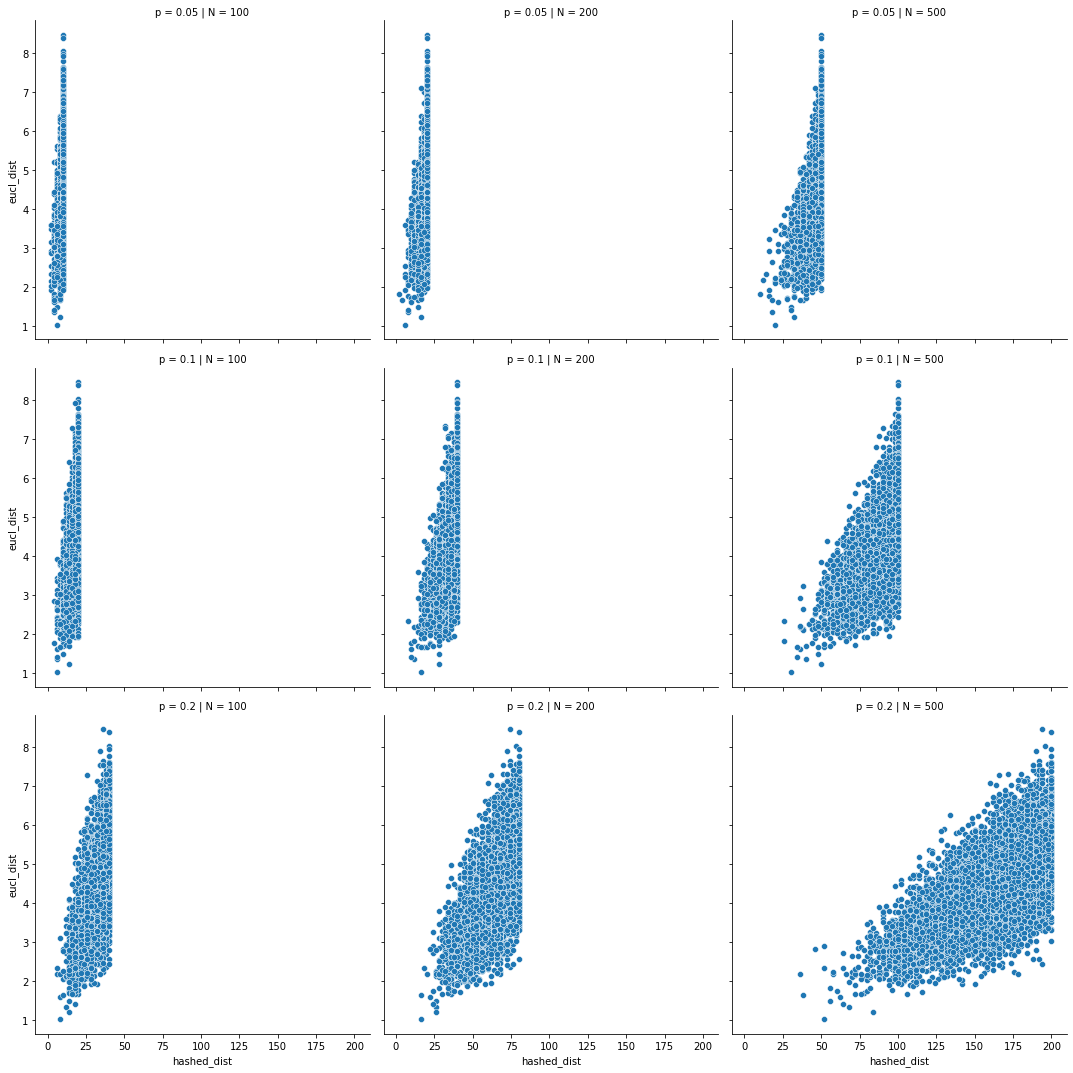

In [15]:
g = sns.relplot(x="hashed_dist", y="eucl_dist", col="N", row="p", data=res, kind="scatter")
g

### N = 100, p = 0.05, dim=10

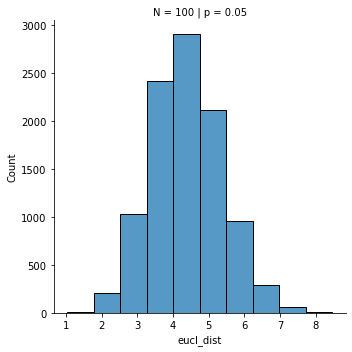

In [16]:
sns.displot(data=res[(res.N==100) &(res.p==0.05)], bins=10, kind="hist", x="eucl_dist", row="N", col="p")

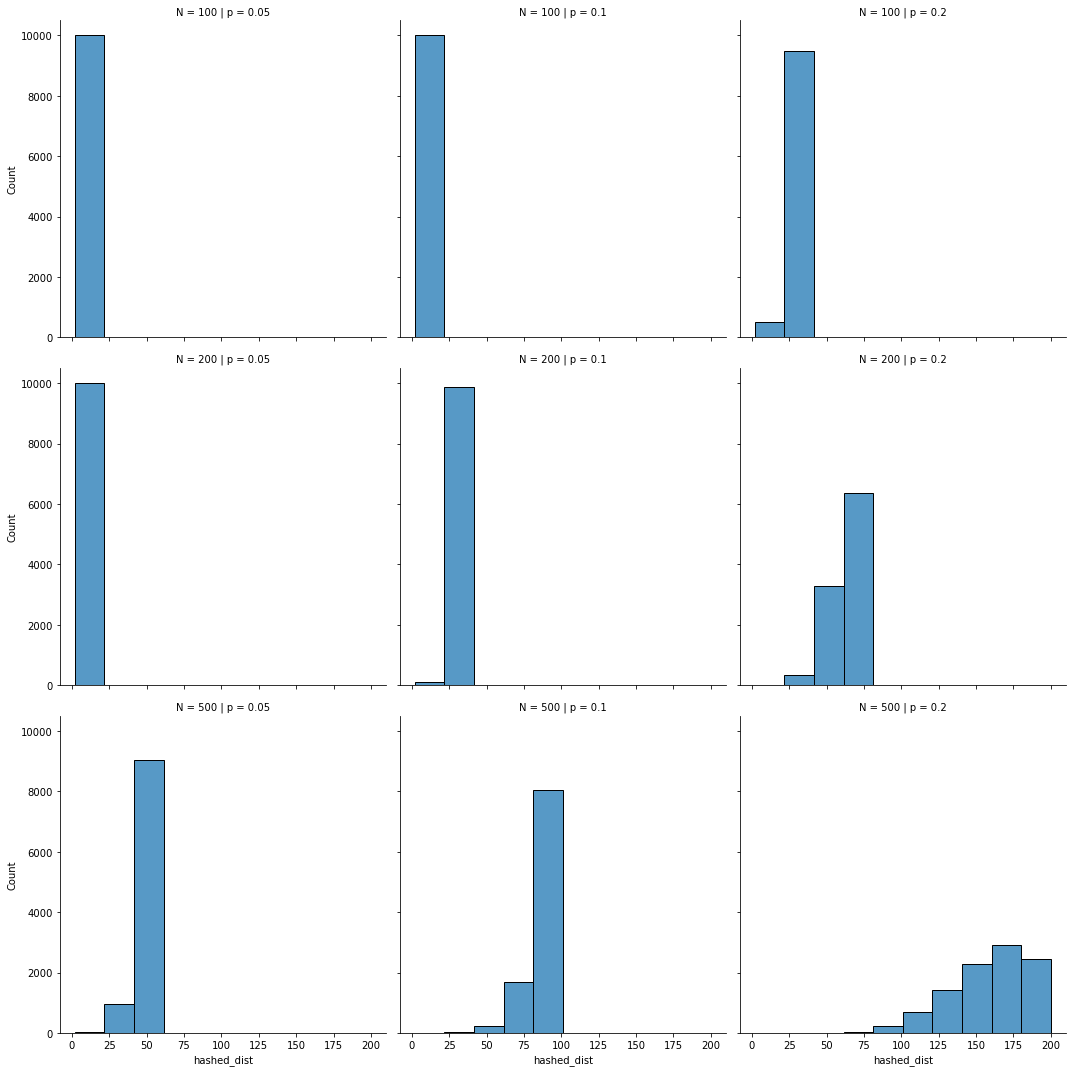

In [17]:
sns.displot(data=res, bins=10, kind="hist", x="hashed_dist", row="N", col="p")

In [18]:
avg = res.groupby(['hashed_dist', 'N', 'p'], as_index=False).mean()

std = res.groupby(['hashed_dist', 'N', 'p'], as_index=False).std()

In [19]:
N100_p005 = res[(res.N==100)&(res.p==0.05)]

### Joint plot

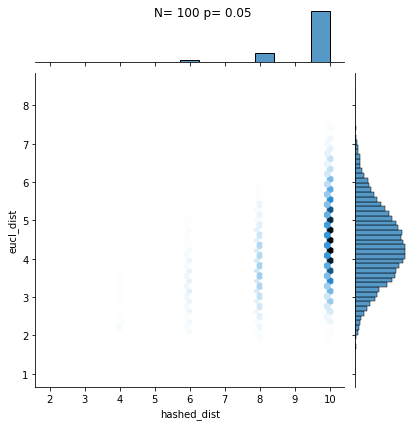

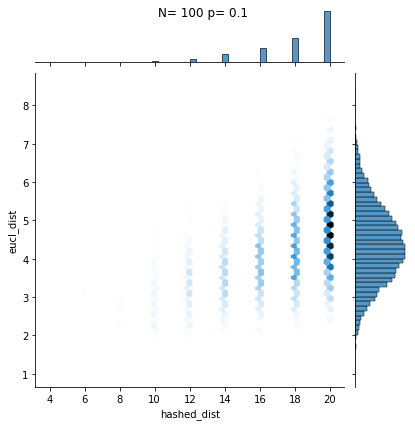

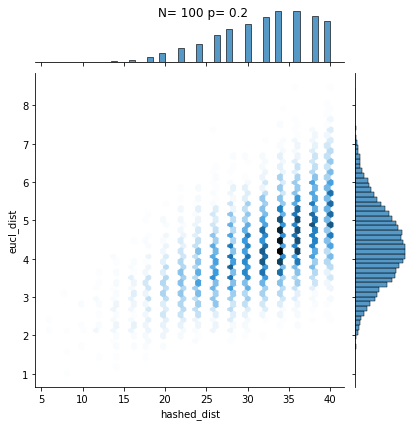

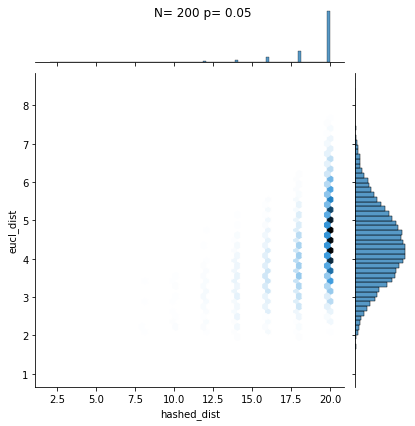

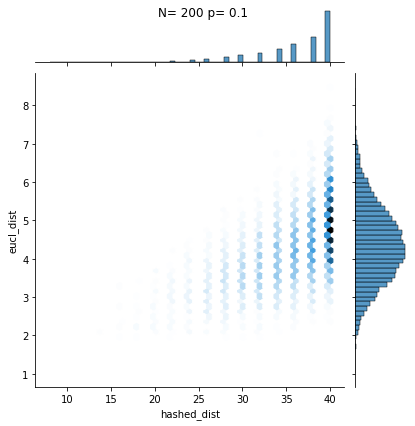

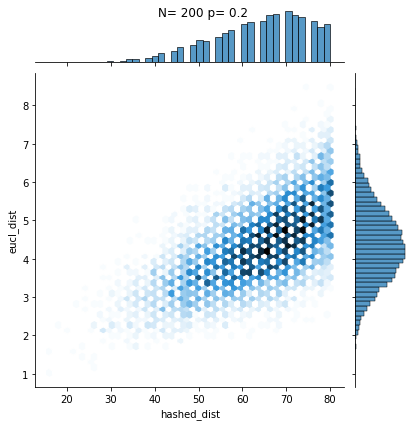

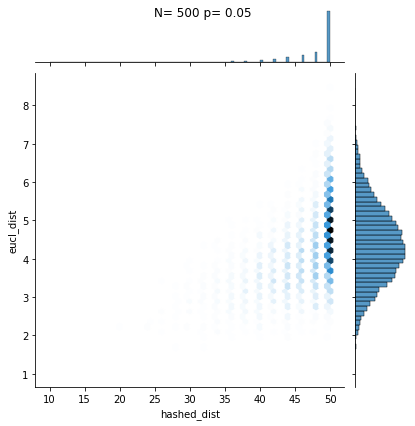

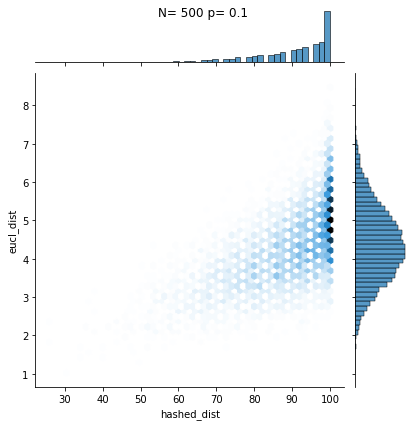

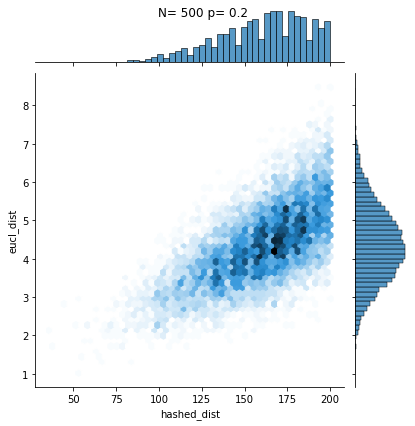

In [20]:
for N_ in [100,200,500]:
    for p_ in [0.05, 0.1, 0.2]:
        df = res[(res.N==N_)&(res.p==p_)]
        g = sns.jointplot(data=df, x="hashed_dist", y="eucl_dist", kind="hex")
        g.fig.suptitle('N= '+ str(N_)+ " p= "+ str(p_))
        g


### Catplot - hamming dist & euclidean dist

/Users/nika/miniconda/envs/am/lib/python3.9/site-packages/seaborn/categorical.py:3808: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


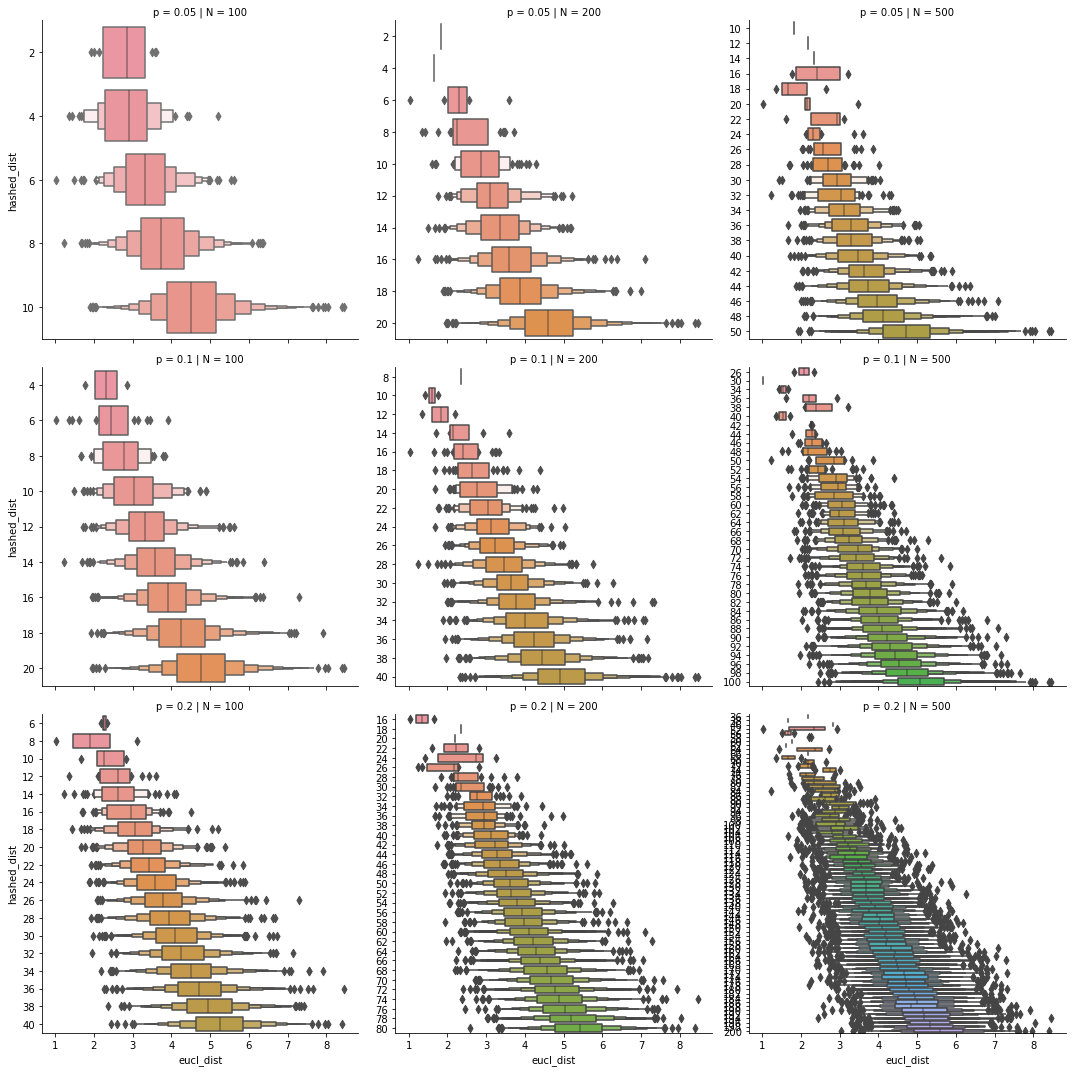

In [21]:
fig = sns.catplot(data=res, y="hashed_dist",x="eucl_dist", col="N", row="p", kind="boxen", sharey=False, orient="h")
fig

### Average hamming dist data - mean and standard deviation

In [13]:
mean_df = res.groupby(by=["N","p","hashed_dist"], as_index=False).mean()
std_df = res.groupby(by=["N","p","hashed_dist"], as_index=False).std()

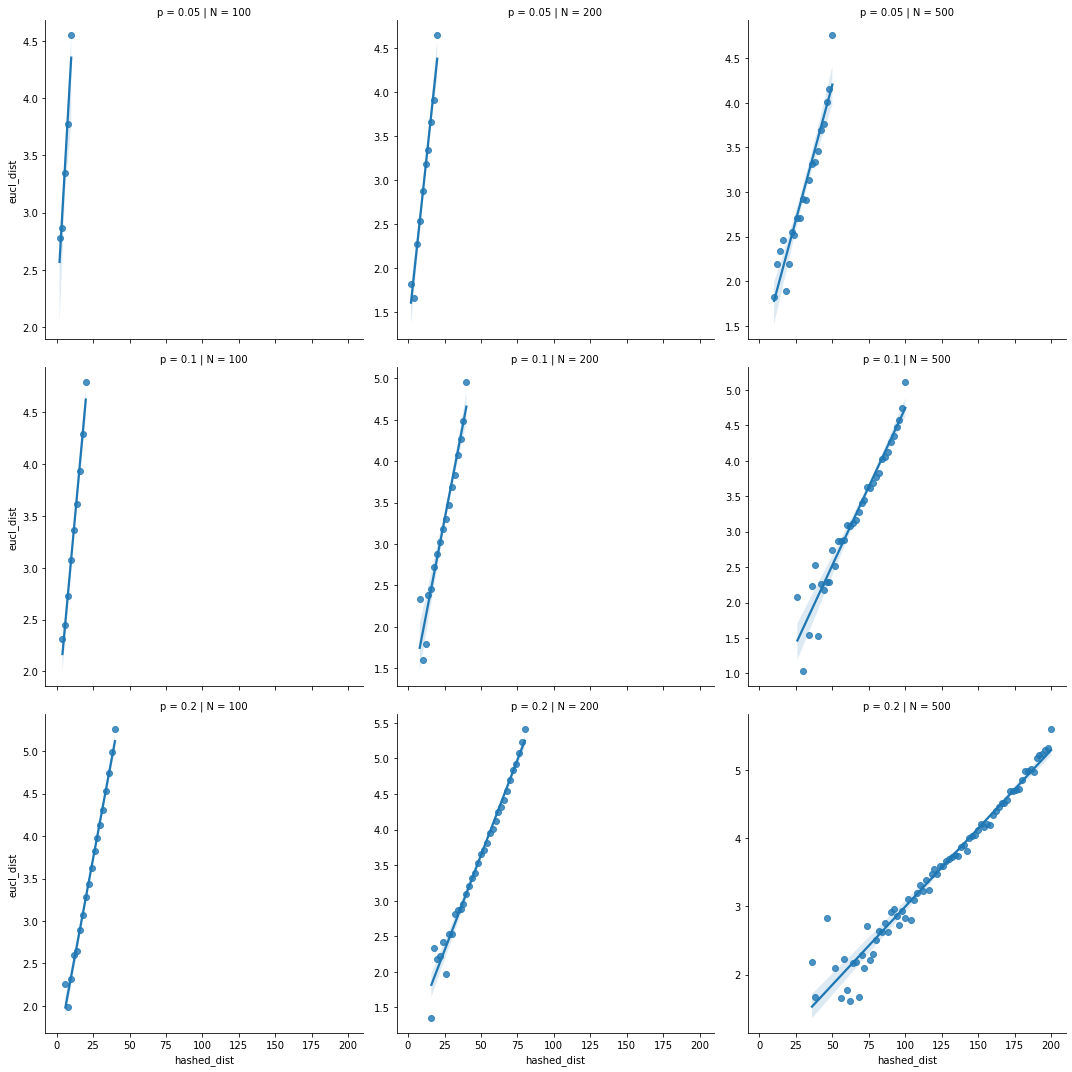

In [23]:
fig = sns.lmplot(data=mean_df, x="hashed_dist",y="eucl_dist", col="N", row="p", facet_kws={'sharey':False})


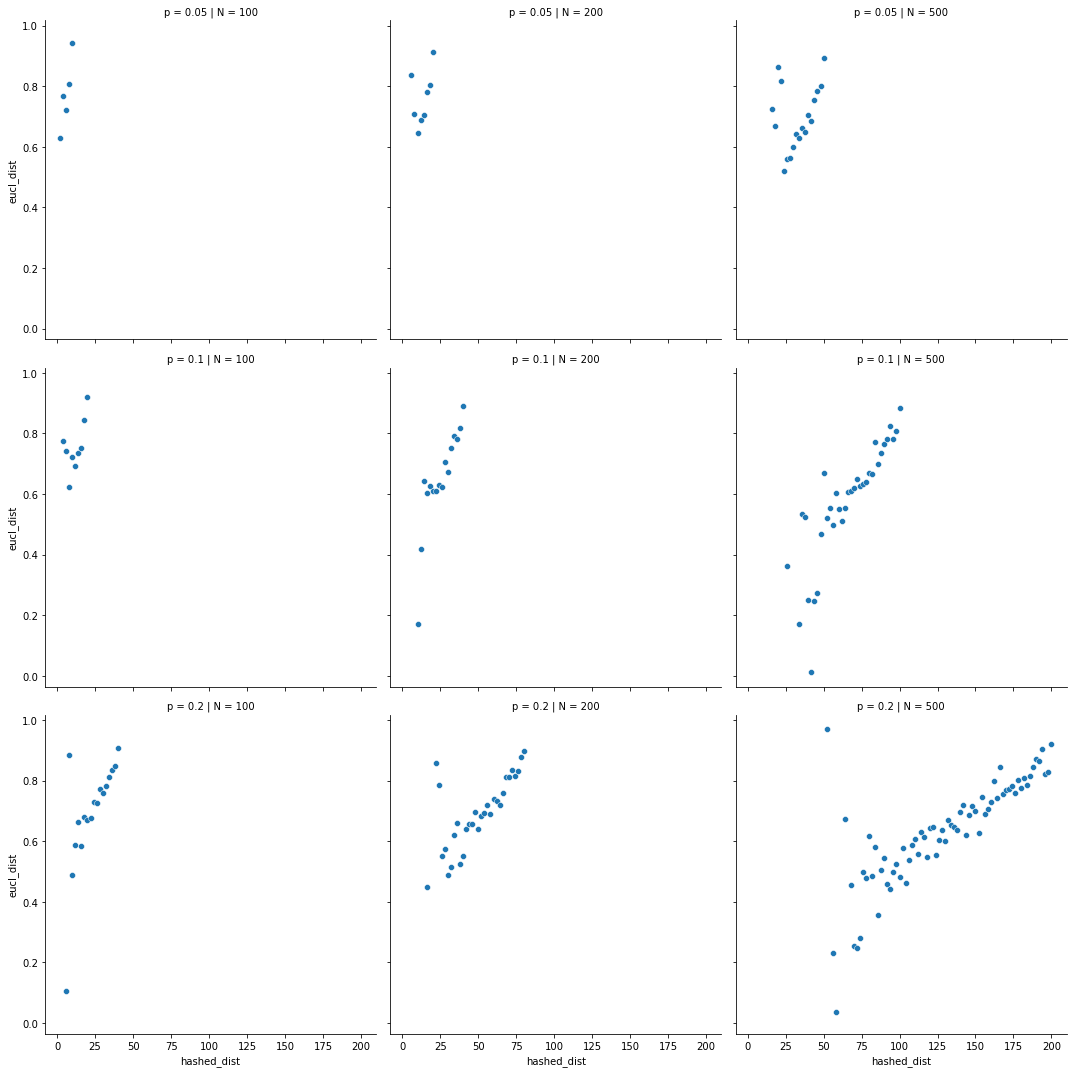

In [24]:
fig = sns.relplot(data=std_df, x="hashed_dist",y="eucl_dist", col="N", row="p")


### Euclidean distance < 100

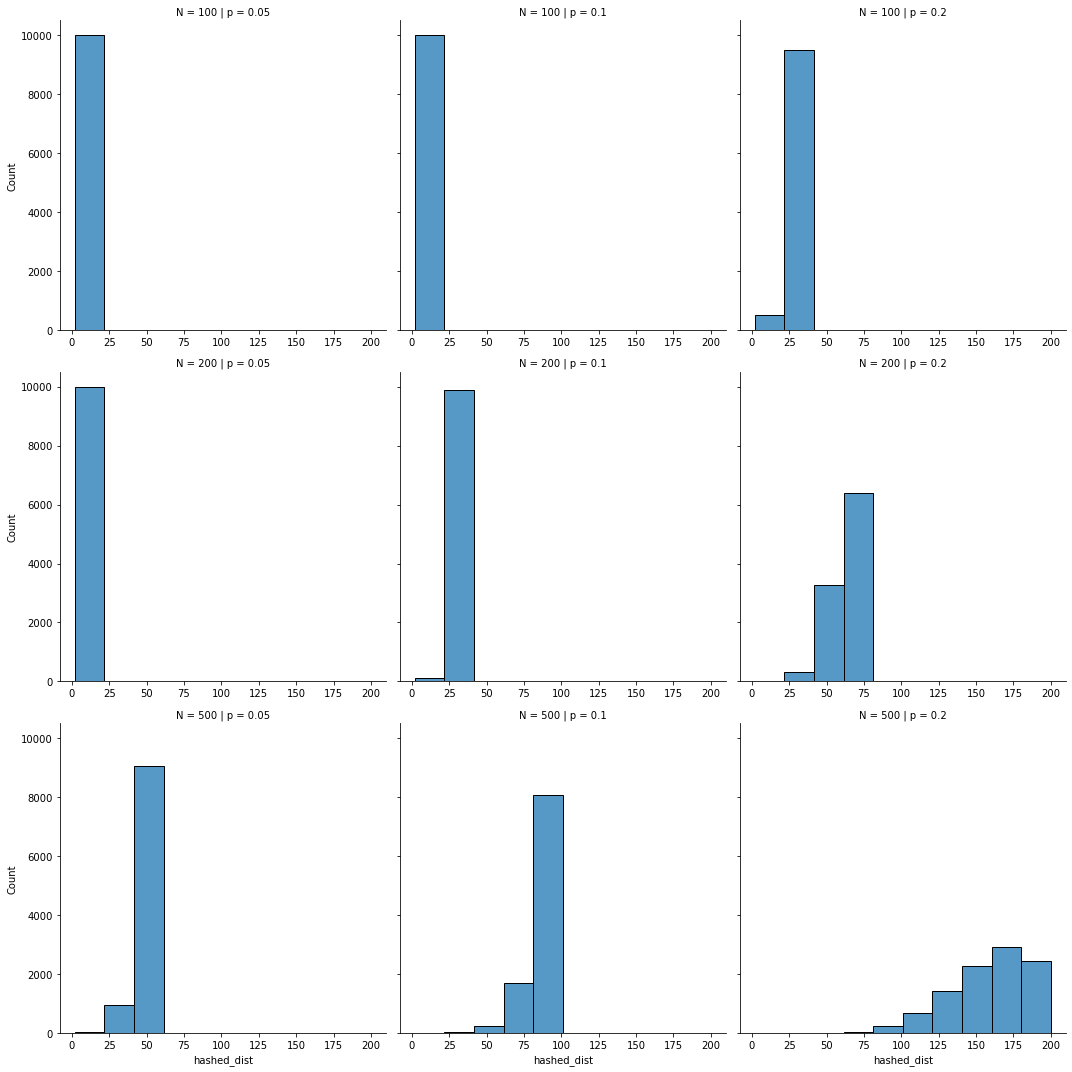

In [25]:
eucl_100 = res[res.eucl_dist < 100]

sns.displot(data=eucl_100, bins=10, kind="hist", x="hashed_dist", row="N", col="p", facet_kws={'sharex':False})

### S2 distance

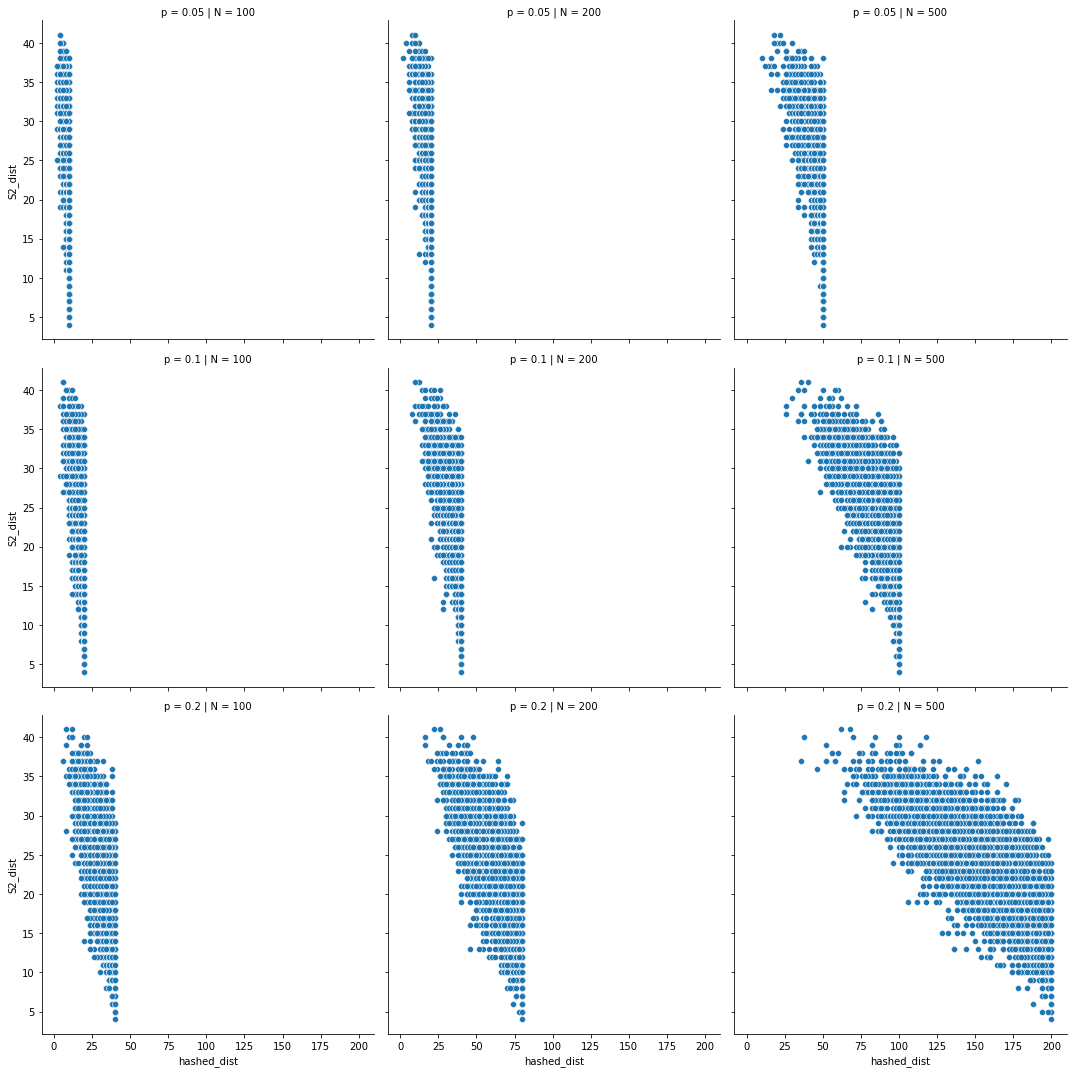

In [27]:
g = sns.relplot(x="hashed_dist", y="S2_dist", col="N", row="p", data=res, kind="scatter")
g

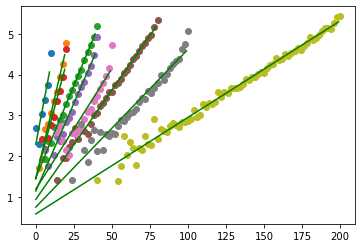

In [15]:
lin_m = {"N":[],"p":[],"intercept":[], "slope":[]}

for N_ in mean_df.N.unique():
    for p_ in mean_df.p.unique():
        avg_df = mean_df[(mean_df.N==N_)&(mean_df.p==p_)]

        linear_model=np.polyfit(avg_df.hashed_dist,avg_df.eucl_dist,1)
        linear_model_fn=np.poly1d(linear_model)
        lin_m["N"].append(N_)
        lin_m["p"].append(p_)
        lin_m["intercept"].append(linear_model[1])
        lin_m["slope"].append(linear_model[0])
        
        plt.scatter(x=avg_df.hashed_dist, y=avg_df.eucl_dist)
        x_s=np.arange(0,int(np.max(avg_df.hashed_dist)))
        plt.plot(x_s,linear_model_fn(x_s),color="green")

In [16]:
coeff_df = pd.DataFrame(lin_m)
coeff_df.to_csv("./lin_mod_params.csv")

In [17]:
coeff_df

N     p  intercept     slope
0  100  0.05   2.287425  0.197256
1  100  0.10   1.439331  0.160306
2  100  0.20   1.467369  0.090506
3  200  0.05   1.449275  0.140925
4  200  0.10   1.140756  0.086059
5  200  0.20   0.935205  0.053691
6  500  0.05   1.187085  0.059206
7  500  0.10   0.745572  0.038733
8  500  0.20   0.578117  0.023700

In [19]:
pred_df = []
for N_ in mean_df.N.unique():
    for p_ in mean_df.p.unique():
        avg_df = mean_df[(mean_df.N==N_)&(mean_df.p==p_)]
        linear_model=np.polyfit(avg_df.hashed_dist,avg_df.eucl_dist,1)
        slope = linear_model[0]
        intercept = linear_model[1]
#         avg_df.copy()["pred"] = slope * avg_df.hashed_dist + intercept
        avg_df = avg_df.assign(pred=lambda x: slope * x.hashed_dist + intercept)
        pred_df.append(avg_df)

pred_df = pd.concat(pred_df)

pred_df

N     p  hashed_dist  eucl_dist    S2_dist      pred
0    100  0.05            0   2.695001  36.000000  2.287425
1    100  0.05            2   2.291082  33.250000  2.681938
2    100  0.05            4   3.031384  31.839506  3.076451
3    100  0.05            6   3.366117  29.575893  3.470964
4    100  0.05            8   3.735915  26.862379  3.865476
..   ...   ...          ...        ...        ...       ...
219  500  0.20          192   5.148693  16.587678  5.128521
220  500  0.20          194   5.111334  16.028986  5.175921
221  500  0.20          196   5.274630  15.678571  5.223321
222  500  0.20          198   5.404052  14.905028  5.270721
223  500  0.20          200   5.431335  12.767025  5.318121

[224 rows x 6 columns]

In [ ]:
np.average((avg_df["pred"] - avg_df.eucl_dist)**2)

In [20]:
fname = './output/data_100N.csv'
df100 = pd.read_csv(fname)
# del df['Unnamed: 0']
df100.type = df100['type'].map({'known':'orig', 'new':'noisy'})

fname = './output/data_200N.csv'
df200 = pd.read_csv(fname)
# del df['Unnamed: 0']
df200.type = df200['type'].map({'known':'orig', 'new':'noisy'})

fname = './output/data_500N.csv'
df500 = pd.read_csv(fname)
# del df['Unnamed: 0']
df500.type = df500['type'].map({'known':'orig', 'new':'noisy'})

In [21]:
df_100_ = df100[(df100.type == "noisy") & ((df100.p == 0.05) | (df100.p == 0.1) | (df100.p == 0.2))]

df_200_ = df200[(df200.type == "noisy") & ((df200.p == 0.05) | (df200.p == 0.1) | (df200.p == 0.2))]

df_500_ = df500[(df500.type == "noisy") & ((df500.p == 0.05) | (df500.p == 0.1) | (df500.p == 0.2))]

df_all = pd.concat([df_100_,df_200_,df_500_])

In [22]:
N = set(df_all.N)
n = set(df_all.n)
d = set(df_all.d)
p = set(df_all.p)
U = set(df_all.U)
g = set(df_all.g)
N = np.sort(list(N))
n = np.sort(list(n))
d = np.sort(list(d))
p = np.sort(list(p))

# df_n = df_n.groupby(by=["N","n","d","p","U","g"], as_index=False)["errors"].mean()

In [37]:
df_all

Unnamed: 0  threshold    N   n  errors    p     k   type   g    U  \
64               64      4.220  100  64      20  0.2   579  noisy   4  5.0   
65               65      4.220  100  64      15  0.2   682  noisy   4  5.0   
66               66      4.220  100  64      19  0.2   627  noisy   4  5.0   
67               67      4.220  100  64      22  0.2   682  noisy   4  5.0   
68               68      4.220  100  64       3  0.2   148  noisy   4  5.0   
...             ...        ...  ...  ..     ...  ...   ...    ...  ..  ...   
4354555          27     -3.336  500  16      40  0.1  3949  noisy  64  3.0   
4354556          28     -3.336  500  16       1  0.1  1656  noisy  64  3.0   
4354557          29     -3.336  500  16       0  0.1  2166  noisy  64  3.0   
4354558          30     -3.336  500  16      40  0.1  3744  noisy  64  3.0   
4354559          31     -3.336  500  16      41  0.1  3873  noisy  64  3.0   

            d  seed  
64       0.01    27  
65       0.01    27  
66       0.01    27  
67       0.01    27  
68       0.01    27  
...       ...   ...  
4354555  0.10    27  
4354556  0.10    27  
4354557  0.10    27  
4354558  0.10    27  
4354559  0.10    27  

[6531840 rows x 12 columns]

In [23]:
list_df = []
list_df_2 = []

for N_ in N:
    for p_ in p:
        coeff_filt = coeff_df[(coeff_df.N==N_) & (coeff_df.p == p_)]
        df_filt = df_all[(df_all.N==N_) & (df_all.p==p_)]
        list_df.append(df_filt.assign(eucl_eq=lambda x: float(coeff_filt.slope) * x.errors + float(coeff_filt.intercept)))
        list_df_2.append(df_filt.assign(max_err=lambda x: 2 * x.p * x.N))

pred_all = pd.concat(list_df)

list_df = []

for N_ in N:
    for p_ in p:
        df_filt = pred_all[(pred_all.N==N_) & (pred_all.p==p_)]
        list_df.append(df_filt.assign(max_err=lambda x: 2 * x.p * x.N))
pred_all = pd.concat(list_df)


In [24]:
pred_all

Unnamed: 0  threshold    N    n  errors     p     k   type     g  \
640             512      3.180  100  512       5  0.05   186  noisy    16   
641             513      3.180  100  512       7  0.05   249  noisy    16   
642             514      3.180  100  512       8  0.05   303  noisy    16   
643             515      3.180  100  512       5  0.05   213  noisy    16   
644             516      3.180  100  512       5  0.05   597  noisy    16   
...             ...        ...  ...  ...     ...   ...   ...    ...   ...   
4354523         123  -1598.208  500   64       0  0.20  3545  noisy  8192   
4354524         124  -1598.208  500   64       0  0.20  3351  noisy  8192   
4354525         125  -1598.208  500   64       0  0.20  2131  noisy  8192   
4354526         126  -1598.208  500   64       0  0.20  2402  noisy  8192   
4354527         127  -1598.208  500   64       0  0.20  2092  noisy  8192   

            U     d  seed   eucl_eq  max_err  
640       3.9  0.10    27  3.273707     10.0  
641       3.9  0.10    27  3.668220     10.0  
642       3.9  0.10    27  3.865476     10.0  
643       3.9  0.10    27  3.273707     10.0  
644       3.9  0.10    27  3.273707     10.0  
...       ...   ...   ...       ...      ...  
4354523  32.0  0.05    27  0.578117    200.0  
4354524  32.0  0.05    27  0.578117    200.0  
4354525  32.0  0.05    27  0.578117    200.0  
4354526  32.0  0.05    27  0.578117    200.0  
4354527  32.0  0.05    27  0.578117    200.0  

[6531840 rows x 14 columns]

In [25]:
df_100_ = df100[(df100.type == "orig") & ((df100.p == 0.05) | (df100.p == 0.1) | (df100.p == 0.2))]

df_200_ = df200[(df200.type == "orig") & ((df200.p == 0.05) | (df200.p == 0.1) | (df200.p == 0.2))]

df_500_ = df500[(df500.type == "orig") & ((df500.p == 0.05) | (df500.p == 0.1) | (df500.p == 0.2))]

df_all_orig = pd.concat([df_100_,df_200_,df_500_])

In [26]:
df_all_orig

Unnamed: 0  threshold    N   n  errors    p     k  type   g    U  \
0                 0      4.220  100  64      20  0.2   579  orig   4  5.0   
1                 1      4.220  100  64      15  0.2   682  orig   4  5.0   
2                 2      4.220  100  64      19  0.2   627  orig   4  5.0   
3                 3      4.220  100  64      24  0.2  1348  orig   4  5.0   
4                 4      4.220  100  64       3  0.2   148  orig   4  5.0   
...             ...        ...  ...  ..     ...  ...   ...   ...  ..  ...   
4354539          11     -3.336  500  16      40  0.1  1951  orig  64  3.0   
4354540          12     -3.336  500  16       1  0.1  1656  orig  64  3.0   
4354541          13     -3.336  500  16       0  0.1     0  orig  64  3.0   
4354542          14     -3.336  500  16      40  0.1  3744  orig  64  3.0   
4354543          15     -3.336  500  16       2  0.1  1871  orig  64  3.0   

            d  seed  
0        0.01    27  
1        0.01    27  
2        0.01    27  
3        0.01    27  
4        0.01    27  
...       ...   ...  
4354539  0.10    27  
4354540  0.10    27  
4354541  0.10    27  
4354542  0.10    27  
4354543  0.10    27  

[6531840 rows x 12 columns]

In [27]:
list_df = []

for N_ in N:
    for p_ in p:
        coeff_filt = coeff_df[(coeff_df.N==N_) & (coeff_df.p == p_)]
        df_filt = df_all_orig[(df_all_orig.N==N_) & (df_all_orig.p==p_)]
        list_df.append(df_filt.assign(eucl_eq=lambda x: float(coeff_filt.slope) * x.errors + float(coeff_filt.intercept)))  
pred_all_orig = pd.concat(list_df)


list_df = []

for N_ in N:
    for p_ in p:
        df_filt = pred_all_orig[(pred_all_orig.N==N_) & (pred_all_orig.p==p_)]
        list_df.append(df_filt.assign(max_err=lambda x: 2 * x.p * x.N))
pred_all_orig = pd.concat(list_df)

In [28]:
df_Ug = pred_all_orig[(pred_all_orig.U == 4) & (pred_all_orig.g==1024)]

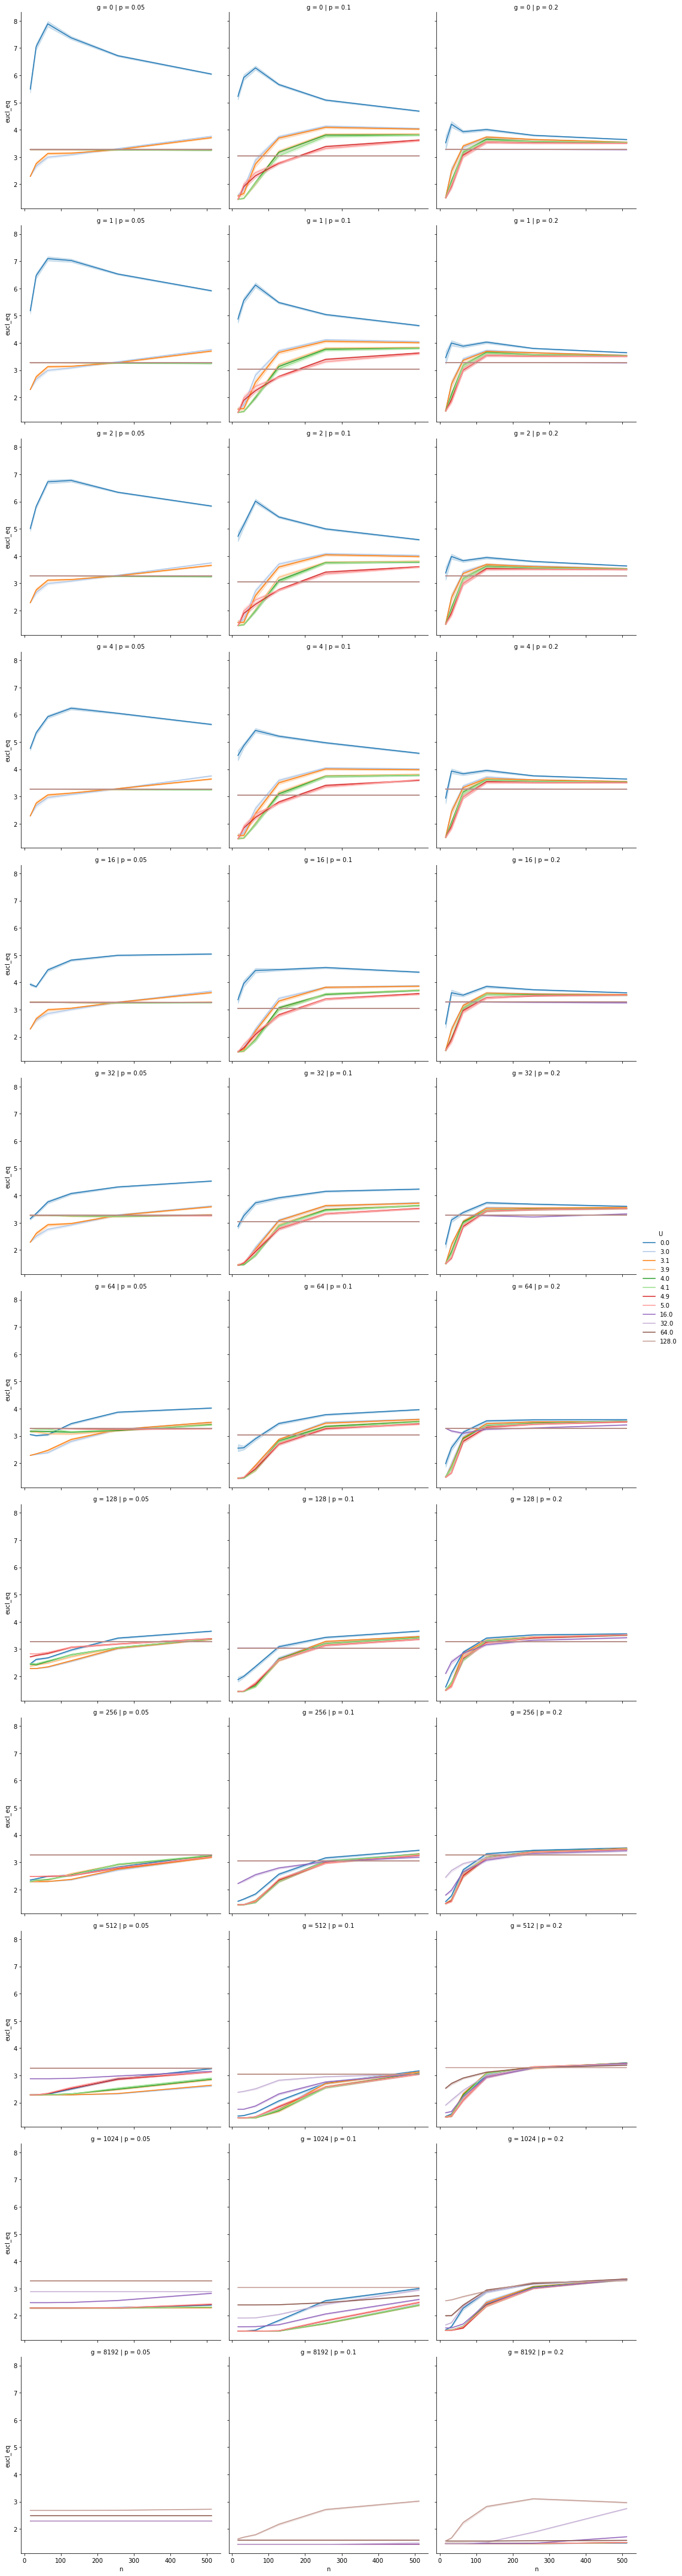

In [29]:
df_N100 = pred_all_orig[(pred_all_orig.N==100)]
g = sns.relplot(x="n", y="eucl_eq", col="p", row="g", hue="U", data=df_N100, kind="line", palette="tab20") #, ci=None
g

In [30]:
pred_all_orig.d = 0.0
pred_all_orig

Unnamed: 0  threshold    N    n  errors     p    k  type     g     U  \
128               0      3.180  100  512       5  0.05  521  orig    16   3.9   
129               1      3.180  100  512       4  0.05   67  orig    16   3.9   
130               2      3.180  100  512       7  0.05  288  orig    16   3.9   
131               3      3.180  100  512       5  0.05  213  orig    16   3.9   
132               4      3.180  100  512       5  0.05   84  orig    16   3.9   
...             ...        ...  ...  ...     ...   ...  ...   ...   ...   ...   
4354459          59  -1598.208  500   64       0  0.20    0  orig  8192  32.0   
4354460          60  -1598.208  500   64       0  0.20    0  orig  8192  32.0   
4354461          61  -1598.208  500   64       0  0.20    0  orig  8192  32.0   
4354462          62  -1598.208  500   64       0  0.20    0  orig  8192  32.0   
4354463          63  -1598.208  500   64       0  0.20    0  orig  8192  32.0   

           d  seed   eucl_eq  max_err  
128      0.0    27  3.273707     10.0  
129      0.0    27  3.076451     10.0  
130      0.0    27  3.668220     10.0  
131      0.0    27  3.273707     10.0  
132      0.0    27  3.273707     10.0  
...      ...   ...       ...      ...  
4354459  0.0    27  0.578117    200.0  
4354460  0.0    27  0.578117    200.0  
4354461  0.0    27  0.578117    200.0  
4354462  0.0    27  0.578117    200.0  
4354463  0.0    27  0.578117    200.0  

[6531840 rows x 14 columns]

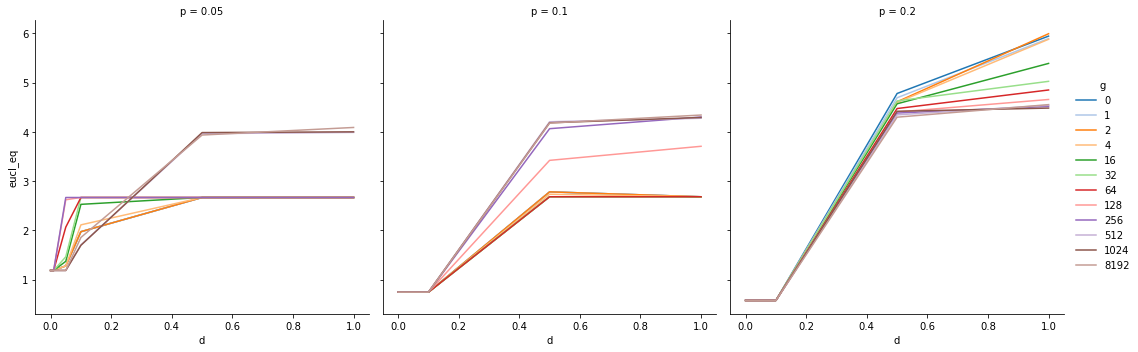

In [40]:
preds_d = pd.concat((pred_all, pred_all_orig))
df_N100 = preds_d[(preds_d.N==500) & (preds_d.n==32) & (preds_d.U==16)]
g = sns.relplot(x="d", y="eucl_eq", col="p", hue="g", data=df_N100, kind="line", palette="tab20", ci=None) #, ci=None
g

In [50]:
d

array([0.01, 0.05, 0.1 , 0.5 , 1.  ])

TypeError: object of type 'float' has no len()

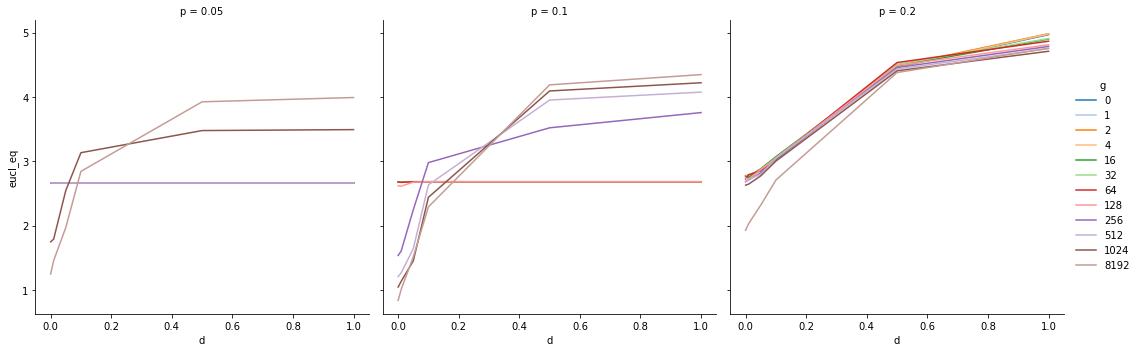

In [41]:
N_fixed = 500
df_N100 = preds_d[(preds_d.N==N_fixed) & (preds_d.n==256) & (preds_d.U==32)]

g = sns.relplot(x="d", y="eucl_eq", col="p", hue="g", data=df_N100, kind="line", palette="tab20", ci=None) #, ci=None

for j in range(len(p)):
#     g.axes[0,j].set_yscale('log')
    df_filt = coeff_df[(coeff_df.N==N_fixed) & (coeff_df.p==p[j])]
    g.axes[0,j].axhline(float(df_filt.slope)*2*N_fixed*p[j]+float(df_filt.intercept), ls='--', linewidth=3, color='red') #max error if 100% active vals are displaced
    d_pred = [float(df_filt.slope)*N_fixed*i+float(df_filt.intercept) for i in d]
    g.axes[0,j].plot(d, d_pred) #max error if 100% active vals are displaced

# find problem here


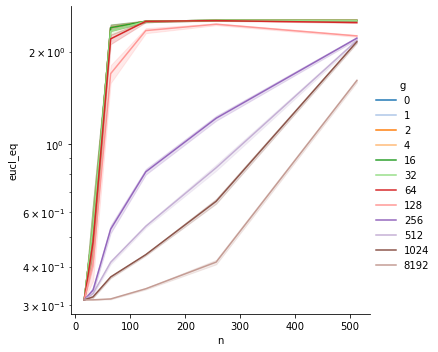

In [81]:
df_N500 = pred_all_orig[(pred_all_orig.N==500) & (pred_all_orig.p==0.1) & (pred_all_orig.U==32)]
g = sns.relplot(x="n", y="eucl_eq", row="U", hue="g", data=df_N500, kind="line", palette="tab20") #, ci=None
g.axes[0,0].set_yscale('log')
g

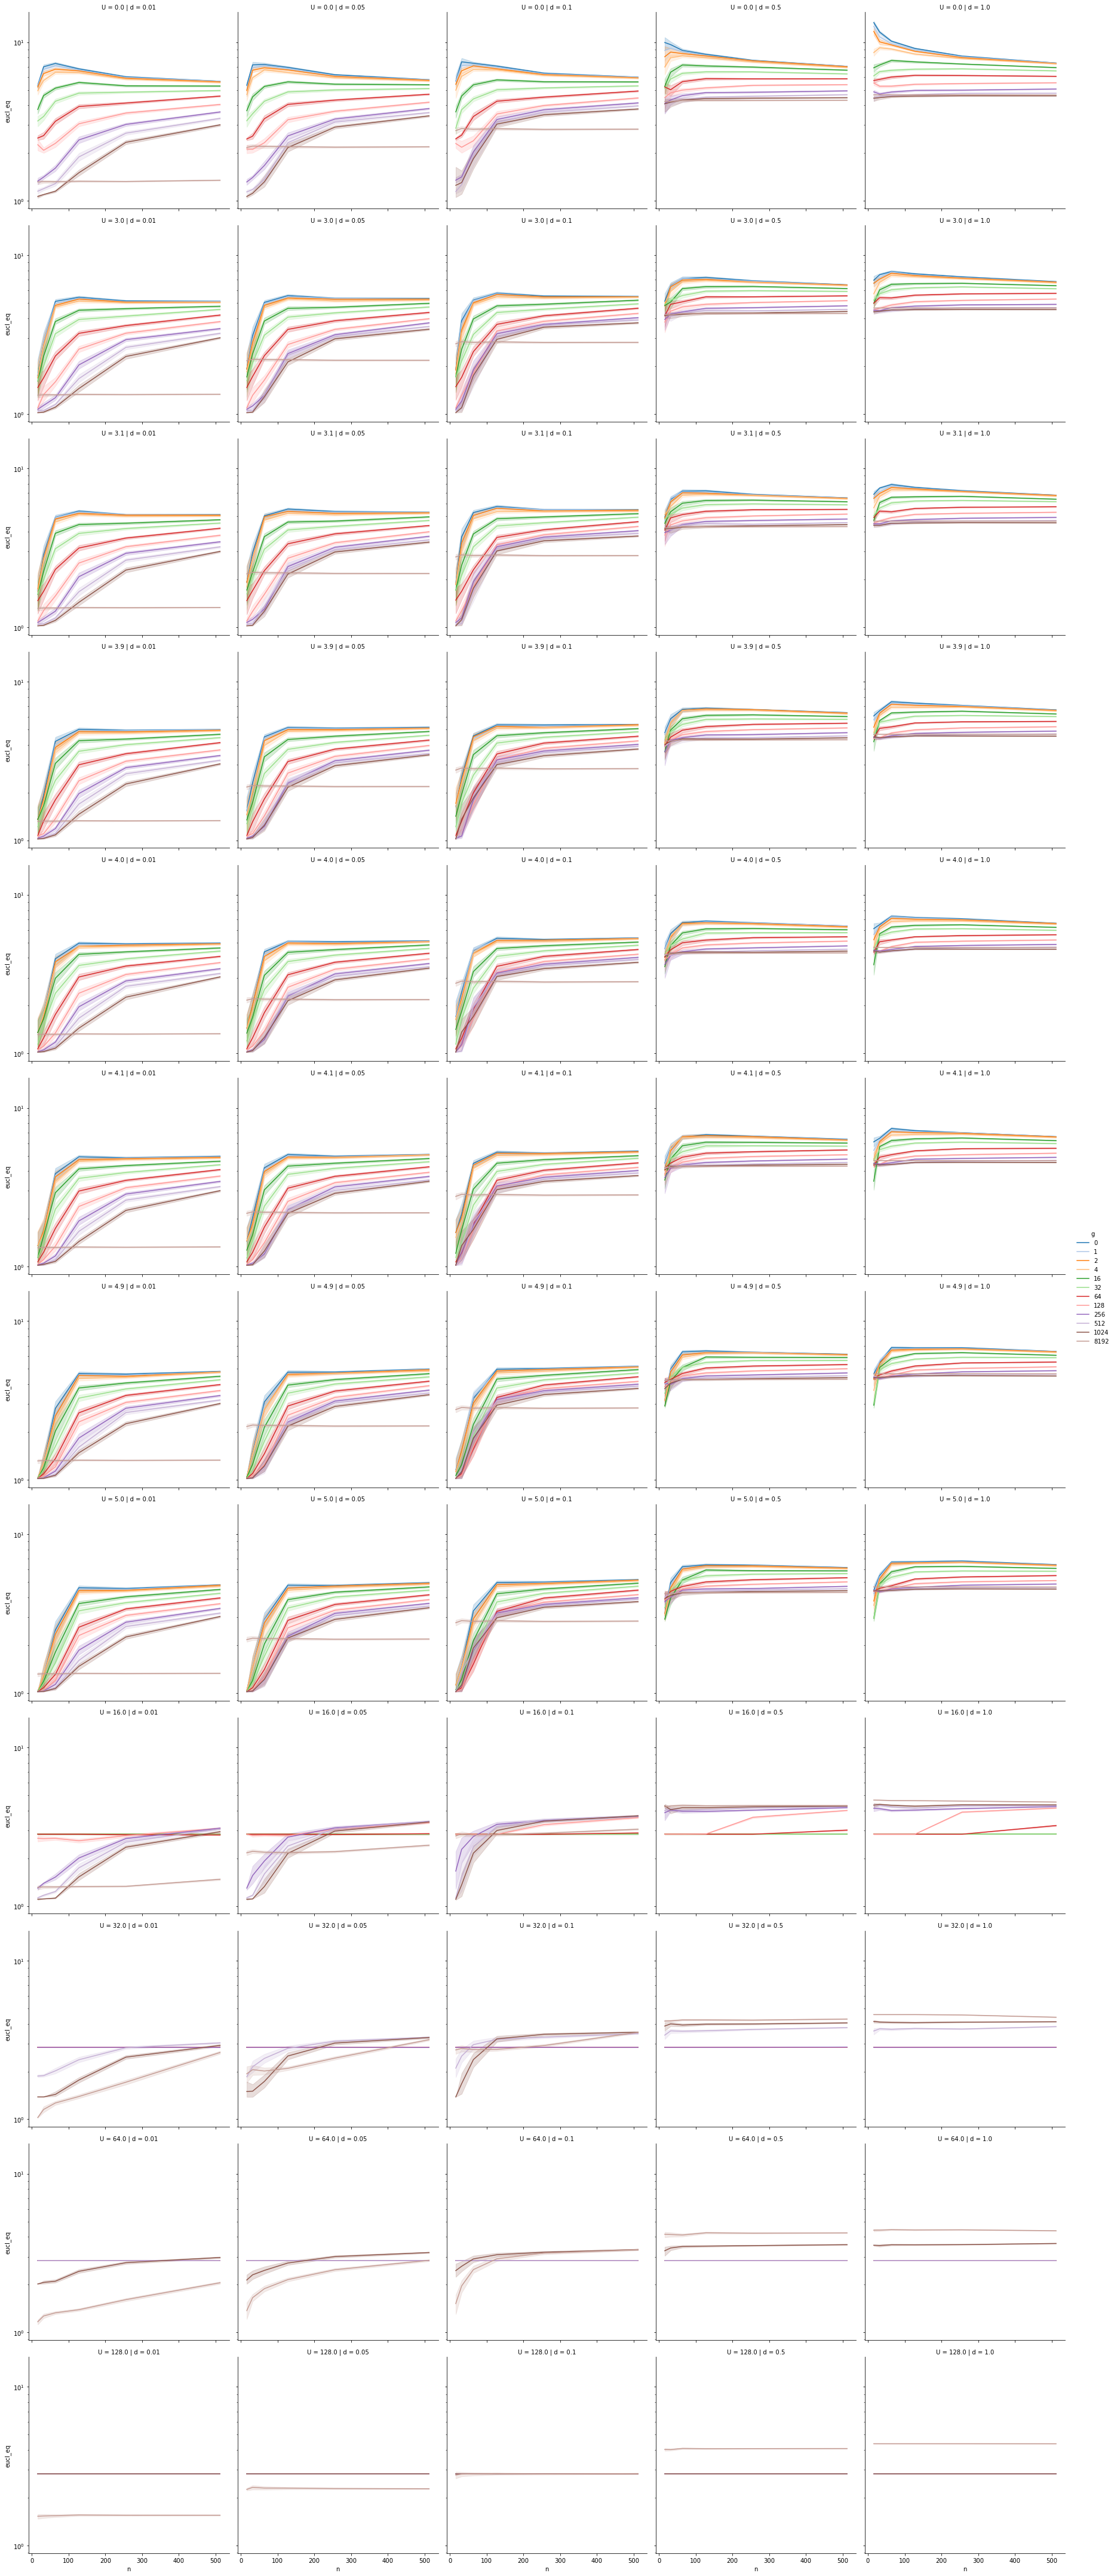

In [83]:
df_N500 = pred_all[(pred_all.N==200) & (pred_all.p==0.1)]
g = sns.relplot(x="n", y="eucl_eq", col="d", row="U", hue="g", data=df_N500, kind="line", palette="tab20") #, ci=None
g.axes[0,0].set_yscale('log')
g

### Make a DF with comparable d across all N

In [42]:
list_df = []

for N_ in coeff_df.N.unique():
    for p_ in coeff_df.p.unique():
        coeff_filt = coeff_df[(coeff_df.N==N_) & (coeff_df.p == p_)]
        df_filt = preds_d[(preds_d.N==N_) & (preds_d.p==p_)]
        list_df.append(df_filt.assign(d_eq=lambda x: float(coeff_filt.slope) * x.d*N_ + float(coeff_filt.intercept)))  
pred_d = pd.concat(list_df)


In [43]:
d = {}

for i in range(6):
    for N_ in coeff_df.N.unique():
        for p_ in coeff_df.p.unique():
            coeff_filt = coeff_df[(coeff_df.N==N_) & (coeff_df.p == p_)]
            d[i,N_,p_] = float(coeff_filt.slope)*i + float(coeff_filt.intercept)           
d

{(0, 100, 0.05): 2.2874249780708347,
 (0, 100, 0.1): 1.4393307833494697,
 (0, 100, 0.2): 1.4673688046611664,
 (0, 200, 0.05): 1.4492747630820315,
 (0, 200, 0.1): 1.1407562888705949,
 (0, 200, 0.2): 0.9352054229068221,
 (0, 500, 0.05): 1.1870853738399993,
 (0, 500, 0.1): 0.7455718499190251,
 (0, 500, 0.2): 0.5781167832520094,
 (1, 100, 0.05): 2.484681402301061,
 (1, 100, 0.1): 1.599636614801191,
 (1, 100, 0.2): 1.5578750162821706,
 (1, 200, 0.05): 1.590199914344208,
 (1, 200, 0.1): 1.2268148678813413,
 (1, 200, 0.2): 0.9888967903935635,
 (1, 500, 0.05): 1.2462916618750557,
 (1, 500, 0.1): 0.7843053013856922,
 (1, 500, 0.2): 0.6018168058820645,
 (2, 100, 0.05): 2.681937826531287,
 (2, 100, 0.1): 1.7599424462529123,
 (2, 100, 0.2): 1.6483812279031749,
 (2, 200, 0.05): 1.7311250656063846,
 (2, 200, 0.1): 1.3128734468920877,
 (2, 200, 0.2): 1.042588157880305,
 (2, 500, 0.05): 1.3054979499101123,
 (2, 500, 0.1): 0.8230387528523593,
 (2, 500, 0.2): 0.6255168285121195,
 (3, 100, 0.05): 2.87919

In [369]:
pred_d

Unnamed: 0  threshold    N    n  errors     p    k   type     g  \
640             512      3.180  100  512       5  0.05  186  noisy    16   
641             513      3.180  100  512       7  0.05  249  noisy    16   
642             514      3.180  100  512       8  0.05  303  noisy    16   
643             515      3.180  100  512       5  0.05  213  noisy    16   
644             516      3.180  100  512       5  0.05  597  noisy    16   
...             ...        ...  ...  ...     ...   ...  ...    ...   ...   
4354459          59  -1598.208  500   64       0  0.20    0   orig  8192   
4354460          60  -1598.208  500   64       0  0.20    0   orig  8192   
4354461          61  -1598.208  500   64       0  0.20    0   orig  8192   
4354462          62  -1598.208  500   64       0  0.20    0   orig  8192   
4354463          63  -1598.208  500   64       0  0.20    0   orig  8192   

            U    d  seed   eucl_eq  max_err      d_eq  
640       3.9  0.1    27  3.239086     10.0  4.354469  
641       3.9  0.1    27  3.685240     10.0  4.354469  
642       3.9  0.1    27  3.908316     10.0  4.354469  
643       3.9  0.1    27  3.239086     10.0  4.354469  
644       3.9  0.1    27  3.239086     10.0  4.354469  
...       ...  ...   ...       ...      ...       ...  
4354459  32.0  0.0    27  0.702576    200.0  0.702576  
4354460  32.0  0.0    27  0.702576    200.0  0.702576  
4354461  32.0  0.0    27  0.702576    200.0  0.702576  
4354462  32.0  0.0    27  0.702576    200.0  0.702576  
4354463  32.0  0.0    27  0.702576    200.0  0.702576  

[13063680 rows x 15 columns]

In [254]:
pred_d[(pred_d.N==N) & (pred_d.p==p) & (pred_d.U==64) & (pred_d.g==0)]

Unnamed: 0  threshold    N   n  errors    p     k   type  g     U  \
327504           16       64.0  200  16      20  0.1  1471  noisy  0  64.0   
327505           17       64.0  200  16      20  0.1   765  noisy  0  64.0   
327506           18       64.0  200  16      20  0.1  1185  noisy  0  64.0   
327507           19       64.0  200  16      20  0.1   615  noisy  0  64.0   
327508           20       64.0  200  16      20  0.1  1471  noisy  0  64.0   
...             ...        ...  ...  ..     ...  ...   ...    ... ..   ...   
4184283          59       64.0  200  32      20  0.1   581  noisy  0  64.0   
4184284          60       64.0  200  32      20  0.1   806  noisy  0  64.0   
4184285          61       64.0  200  32      20  0.1  1185  noisy  0  64.0   
4184286          62       64.0  200  32      20  0.1   621  noisy  0  64.0   
4184287          63       64.0  200  32      20  0.1  1471  noisy  0  64.0   

           d  seed   eucl_eq  max_err      d_eq  
327504   0.1    27  2.838884     40.0  2.838884  
327505   0.1    27  2.838884     40.0  2.838884  
327506   0.1    27  2.838884     40.0  2.838884  
327507   0.1    27  2.838884     40.0  2.838884  
327508   0.1    27  2.838884     40.0  2.838884  
...      ...   ...       ...      ...       ...  
4184283  0.1    27  2.838884     40.0  2.838884  
4184284  0.1    27  2.838884     40.0  2.838884  
4184285  0.1    27  2.838884     40.0  2.838884  
4184286  0.1    27  2.838884     40.0  2.838884  
4184287  0.1    27  2.838884     40.0  2.838884  

[5040 rows x 15 columns]

### Find min_i = highest intercept, max_i = minimum N\*p\*slope+intercept, min_j = min intercept, max_j = maximum N\*p\*slope+intercept

In [50]:
intercepts = []
Np_eq = []

for N in capacity.N.unique():
    for p in capacity.p.unique():
        coeff_filt = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        print("N,p: ", N,p)
        print(float(coeff_filt.intercept))
        print(N*p*float(coeff_filt.slope)+float(coeff_filt.intercept))
        intercepts.append(float(coeff_filt.intercept))
        Np_eq.append(N*p*float(coeff_filt.slope)+float(coeff_filt.intercept))

print("max, min ", np.max(intercepts), np.min(Np_eq))

min_i = np.max(intercepts)
max_i = np.min(Np_eq)

min_j =  np.min(intercepts)
max_j = np.max(Np_eq)

N,p:  100 0.05
2.2874249780708347
3.2737070992219657
N,p:  100 0.1
1.4393307833494697
3.0423890978666823
N,p:  100 0.2
1.4673688046611664
3.2774930370812516
N,p:  200 0.05
1.4492747630820315
2.8585262757037966
N,p:  200 0.1
1.1407562888705949
2.8619278690855223
N,p:  200 0.2
0.9352054229068221
3.082860122376478
N,p:  500 0.05
1.1870853738399993
2.6672425747164095
N,p:  500 0.1
0.7455718499190251
2.6822444232523788
N,p:  500 0.2
0.5781167832520094
2.948119046257517
max, min  2.2874249780708347 2.6672425747164095


### Set several thresholds and find which is the smallest stored num of memories n above that threshold

In [51]:
# prendre plusieurs seuils
# chercher n le plus petit
def f(df):        
    df_t = df[df.eucl_eq > df.t]
    if len(df_t)==0:
        n_min = 512
    else:
        n_min = min(df_t.n)
        if n_min == 16:
            n_min = 0
        else:
            n_min = n_min / 2
    return(pd.Series(n_min))
    
# thresholds = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7]
# thresholds = np.linspace(min_i+0.001,max_i-0.001,100)

thresholds = np.linspace(min_j+0.001,max_j-0.001,100) #set to 1000 FIXME

dfs_list = []

mean_d = pred_d.groupby(["N","p","d_eq","U","g","n"], as_index=False).eucl_eq.mean()

for t in thresholds:
    mean_d_copy = mean_d.copy()
    mean_d_copy["t"] = t
    df_grouped = mean_d_copy.groupby(["N","p","d_eq","U","g","t"], as_index=False).apply(f)
#     df_grouped["t"] = t
    dfs_list.append(df_grouped)

capacity = pd.concat(dfs_list)
capacity.rename(columns = {0:'n'}, inplace = True)
capacity = capacity.reset_index()

In [266]:
max_i-min_i,max_j-min_j

(0.40465456168251324, 2.960875707950514)

### Integrate over thresholds: 
- Group by all params except t, n and find sum and max of n

- multiply distance between 2 thresholds and (sum-max), divide by the length of the interval 

In [72]:
integration_thresholds = np.linspace(min_i+0.001,max_i-0.001,1000)
integration_capacity = capacity[(capacity.t>=min_i+0.001) & (capacity.t<max_i-0.001)]

sum_n = integration_capacity.groupby(["N","p","d_eq","U","g"], as_index=False).n.sum()
max_n = integration_capacity.groupby(["N","p","d_eq","U","g"], as_index=False).n.max()

max_n.rename(columns = {'n':'max_n'}, inplace = True)
sum_n.rename(columns = {'n':'sum_n'}, inplace = True)

sum_max = pd.merge(sum_n,max_n)

delta = thresholds[1]-thresholds[0]
sum_max["capacity"] = delta*(sum_max.sum_n-sum_max.max_n)/((max_i-0.001)-(min_i+0.001)) # divide by the length of the interval

sum_max

N     p       d_eq      U     g  sum_n  max_n  capacity
0     100  0.05   2.287425    0.0     0    0.0    0.0       0.0
1     100  0.05   2.287425    0.0     1    0.0    0.0       0.0
2     100  0.05   2.287425    0.0     2    0.0    0.0       0.0
3     100  0.05   2.287425    0.0     4    0.0    0.0       0.0
4     100  0.05   2.287425    0.0    16    0.0    0.0       0.0
...   ...   ...        ...    ...   ...    ...    ...       ...
7771  500  0.20  12.428128  128.0   128    0.0    0.0       0.0
7772  500  0.20  12.428128  128.0   256    0.0    0.0       0.0
7773  500  0.20  12.428128  128.0   512    0.0    0.0       0.0
7774  500  0.20  12.428128  128.0  1024    0.0    0.0       0.0
7775  500  0.20  12.428128  128.0  8192    0.0    0.0       0.0

[7776 rows x 8 columns]

### Integrate over distortion param d

In [53]:
d_list = np.sort(sum_max.d_eq.unique())

for N in sum_max.N.unique():
    for p in sum_max.p.unique():
        Np_filt = sum_max[(sum_max.N==N) & (sum_max.p==p)]
        d_min = Np_filt.d_eq.min()
        d_filt = Np_filt[Np_filt.d_eq==d_min]
        cap_max = d_filt[d_filt.capacity == d_filt.capacity.max()]
        print("U :", cap_max.U.unique(), "\n g: ", cap_max.g.unique())
        # print U,g list that give max capacity

U : [ 0.   3.   3.1  3.9  4.   4.1  4.9  5.  16.  32. ] 
 g:  [8192 1024]
U : [ 0.   3.   3.1  3.9  4.   4.1  4.9  5.  16.  32.  64. ] 
 g:  [8192]
U : [ 0.   3.   3.1  3.9  4.   4.1  4.9  5.  16.  64. ] 
 g:  [8192]
U : [  0.    3.    3.1   3.9   4.    4.1   4.9   5.   16.   32.   64.  128. ] 
 g:  [1024 8192]
U : [  0.    3.    3.1   3.9   4.    4.1   4.9   5.   16.   64.  128. ] 
 g:  [8192]
U : [  0.    3.    3.1   3.9   4.    4.1   4.9   5.  128. ] 
 g:  [8192]
U : [  0.    3.    3.1   3.9   4.    4.1   4.9   5.   16.   32.   64.  128. ] 
 g:  [1024 8192  512   64  128  256]
U : [  0.    3.    3.1   3.9   4.    4.1   4.9   5.   16.   32.   64.  128. ] 
 g:  [8192]
U : [  0.    3.    3.1   3.9   4.    4.1   4.9   5.   16.   32.   64.  128. ] 
 g:  [8192]


In [128]:
for N in sum_max.N.unique():
    for p in sum_max.p.unique():
        Np_filt = sum_max[(sum_max.N==N) & (sum_max.p==p)]
        d_min = Np_filt.d_eq.min()
        d_max = Np_filt.d_eq.max()
        print(N,p,d_min,d_max)

100 0.05 2.2874249780708347 22.01306740109346
100 0.1 1.4393307833494697 17.469913928521596
100 0.2 1.4673688046611664 10.517989966761595
200 0.05 1.4492747630820315 29.63430501551733
200 0.1 1.1407562888705949 18.352472091019873
200 0.2 0.9352054229068221 11.673478920255102
500 0.05 1.1870853738399993 30.7902293913682
500 0.1 0.7455718499190251 20.11229758325256
500 0.2 0.5781167832520094 12.428128098279545


## Integration over d

In [55]:
for N in np.sort(sum_max.N.unique()):
    for p in np.sort(sum_max.p.unique()):
        cf = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        print(N,p,float(cf.slope*N*0.15+cf.intercept))

100 0.05 5.246271341524228
100 0.1 3.843918255125289
100 0.2 2.824961978976231
200 0.05 5.677029300947326
200 0.1 3.7225136591929866
200 0.2 2.545946447509064
500 0.05 5.627556976469229
500 0.1 3.6505807099190557
500 0.2 2.35561848050614


In [380]:
for N in np.sort(sum_max.N.unique()):
    for p in np.sort(sum_max.p.unique()):
        cf = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        print(N,p,float(cf.slope*N*0.2+cf.intercept))

100 0.05 6.585235013009374
100 0.1 4.622389926965396
100 0.2 3.2727528993441073
200 0.05 7.455886085279115
200 0.1 4.658198490060634
200 0.2 3.1041169049161415
500 0.05 7.234775176157652
500 0.1 4.7448388656943035
500 0.2 2.9983753566216613


In [379]:
for N in np.sort(sum_max.N.unique()):
    for p in np.sort(sum_max.p.unique()):
        cf = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        print(N,p,float(cf.slope*N*0.25+cf.intercept))

100 0.05 7.700617899546359
100 0.1 5.389536369303516
100 0.2 3.7340969433972253
200 0.05 8.994536827842005
200 0.1 5.567855757561977
200 0.2 3.6400056816467687
500 0.05 8.749991777272802
500 0.1 5.853079284269481
500 0.2 3.5723252271095993


In [56]:
for N in np.sort(sum_max.N.unique()):
    for p in np.sort(sum_max.p.unique()):
        print("N, p: ",N,p)
        s=" "
        for d in np.sort(pred_d.d.unique()):
            d_eq = float(pred_d[(pred_d.d==d)&(pred_d.N==N)&(pred_d.p==p)].d_eq.unique())
            s=s+"d: "+str(d)+" d_eq: "+str(d_eq)+";"
            
        print(s)
#         print(sum_max[(sum_max.d_eq==d) & (sum_max.N==N) & (sum_max.p==p)].capacity.max())

N, p:  100 0.05
 d: 0.0 d_eq: 2.2874249780708347;d: 0.01 d_eq: 2.484681402301061;d: 0.05 d_eq: 3.2737070992219657;d: 0.1 d_eq: 4.259989220373097;d: 0.5 d_eq: 12.150246189582147;d: 1.0 d_eq: 22.01306740109346;
N, p:  100 0.1
 d: 0.0 d_eq: 1.4393307833494697;d: 0.01 d_eq: 1.599636614801191;d: 0.05 d_eq: 2.2408599406080763;d: 0.1 d_eq: 3.0423890978666823;d: 0.5 d_eq: 9.454622355935534;d: 1.0 d_eq: 17.469913928521596;
N, p:  100 0.2
 d: 0.0 d_eq: 1.4673688046611664;d: 0.01 d_eq: 1.5578750162821706;d: 0.05 d_eq: 1.9198998627661878;d: 0.1 d_eq: 2.372430920871209;d: 0.5 d_eq: 5.992679385711381;d: 1.0 d_eq: 10.517989966761595;
N, p:  200 0.05
 d: 0.0 d_eq: 1.4492747630820315;d: 0.01 d_eq: 1.7311250656063846;d: 0.05 d_eq: 2.8585262757037966;d: 0.1 d_eq: 4.267777788325562;d: 0.5 d_eq: 15.541789889299682;d: 1.0 d_eq: 29.63430501551733;
N, p:  200 0.1
 d: 0.0 d_eq: 1.1407562888705949;d: 0.01 d_eq: 1.3128734468920877;d: 0.05 d_eq: 2.001342078978059;d: 0.1 d_eq: 2.8619278690855223;d: 0.5 d_eq: 9.746

In [76]:
d_list=np.array([0.01,0.05,0.1,0.15,0.2,0.25])
d_eqs = []
d_min_list = []
d_max_list = []

for N in np.sort(sum_max.N.unique()):
    for p in np.sort(sum_max.p.unique()):
        Np_list = []
        for d in np.sort(d_list):
#             d_eq = float(pred_d[(pred_d.d==d)&(pred_d.N==N)&(pred_d.p==p)].d_eq.unique())
            df = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
            d_eq = float(d*N*df.slope + df.intercept)
            d_eqs.append(d_eq)
            Np_list.append(d_eq)
        d_min = np.min(Np_list)
        d_max = np.max(Np_list)
        d_min_list.append(d_min)
        d_max_list.append(d_max)
    
d_min = np.max(d_min_list)
d_max = np.min(d_max_list)
print(d_min,d_max)

2.484681402301061 3.5406196120088937


In [114]:
def integrate_d(df):
    dfd = df.sort_values(by=['d_eq'])
    diff = np.diff(dfd.d_eq)
    result = np.sum(np.array(dfd.capacity)[:-1]*diff)/(np.array(dfd.d_eq)[-1]-np.array(dfd.d_eq)[0])
    return(pd.Series(result))

In [121]:
integration_capacity = sum_max[(sum_max.d_eq>=d_min-0.001) & (sum_max.d_eq<d_max+0.001)]

sum_max_d = integration_capacity.groupby(["N","p","U","g"], as_index=False).apply(integrate_d)
sum_max_d.rename(columns = {0:'d'}, inplace = True)

/var/folders/lj/120wz5w514b36qzycmpr9h9c0000gn/T/ipykernel_3903/1667048831.py:4: RuntimeWarning: invalid value encountered in double_scalars
  result = np.sum(np.array(dfd.capacity)[:-1]*diff)/(np.array(dfd.d_eq)[-1]-np.array(dfd.d_eq)[0])


In [123]:
sum_max_d.d.unique()

array([ 0.        ,  6.92301683, 33.461248  , 42.69193711,  1.15383614,
        2.30767228, 29.99973959, 46.15344552, 27.69206731, 12.69219752,
       11.53836138, 35.76892028,  5.76918069, 41.53810097,  8.07685297,
       18.46137821,  4.61534455,         nan])

### Include d=0

In [ ]:
N=500
p=0.2

cap_filt = capacity[(capacity.N==N) & (capacity.p==p)]

g = sns.relplot(x="t", y="n", col="d_eq", row="g", hue="U", data=cap_filt, kind="line", palette="tab20") #, ci=None
# g.axes[0,0].set_yscale('log')
d_list = np.sort(cap_filt.d_eq.unique())

for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        g.axes[i,j].axvline(x=min_j,linestyle='--')
        coeff_filt = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        g.axes[i,j].axvline(x=float(coeff_filt.intercept),linestyle='-')
        g.axes[i,j].axvline(x=max_j, linestyle='-.')
        g.axes[i,j].axvline(x=min_i, color='r')
        g.axes[i,j].axvline(x=max_i, color='g')
        g.axes[i,j].axvline(x=float(coeff_filt.slope)*N*p+float(coeff_filt.intercept), linestyle=':')

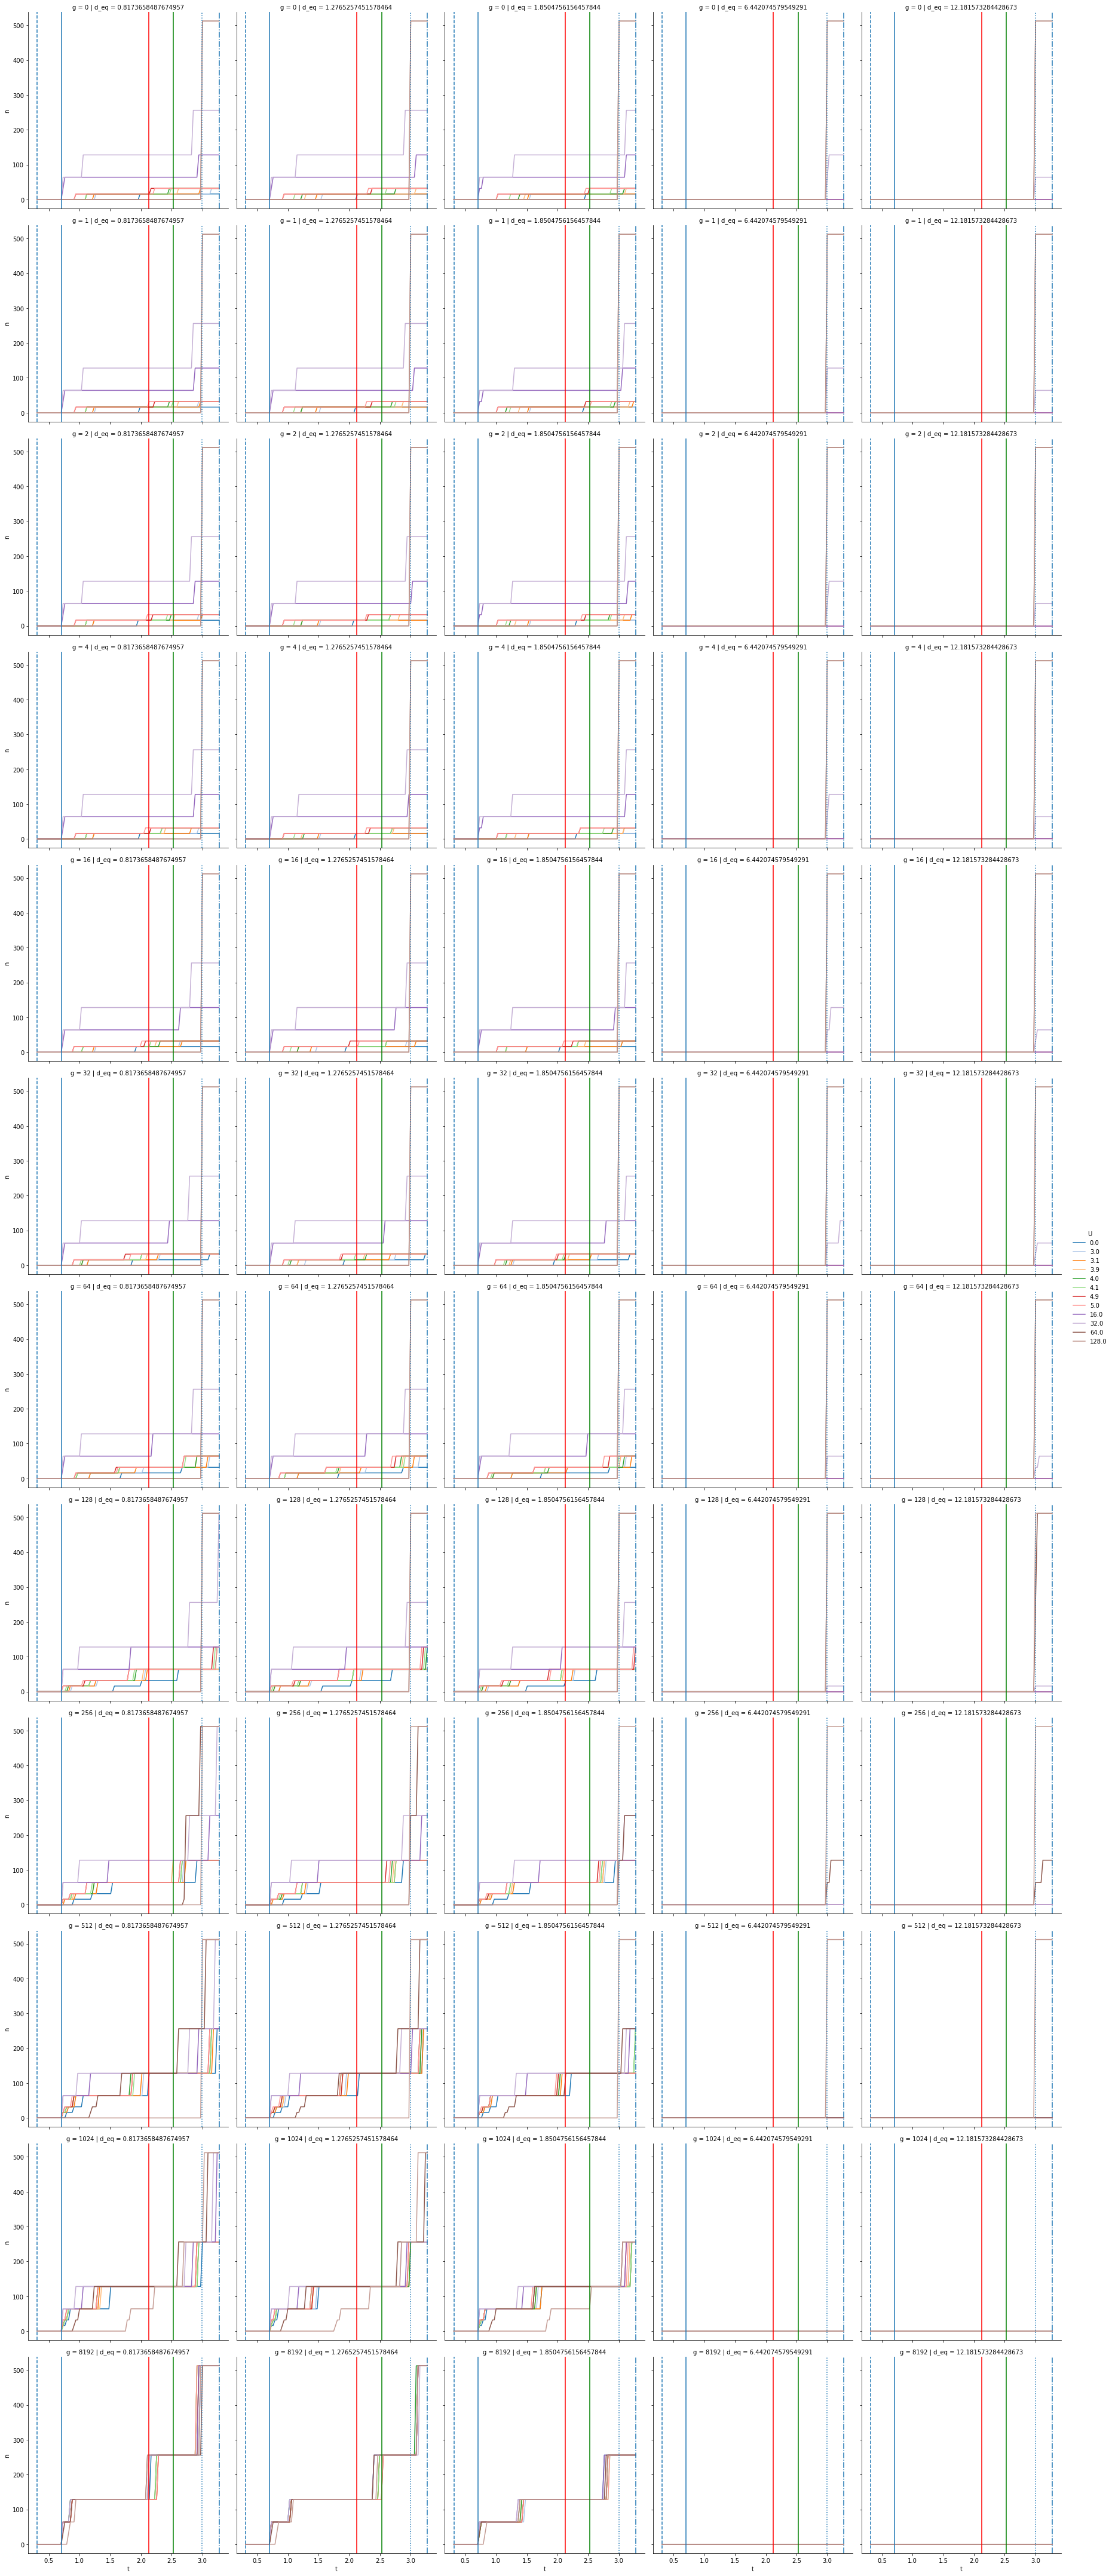

In [301]:
N=500
p=0.2

cap_filt = capacity[(capacity.N==N) & (capacity.p==p)]

g = sns.relplot(x="t", y="n", col="d_eq", row="g", hue="U", data=cap_filt, kind="line", palette="tab20") #, ci=None
# g.axes[0,0].set_yscale('log')
d_list = np.sort(cap_filt.d_eq.unique())

for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        g.axes[i,j].axvline(x=min_j,linestyle='--')
        coeff_filt = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        g.axes[i,j].axvline(x=float(coeff_filt.intercept),linestyle='-')
        g.axes[i,j].axvline(x=max_j, linestyle='-.')
        g.axes[i,j].axvline(x=min_i, color='r')
        g.axes[i,j].axvline(x=max_i, color='g')
        g.axes[i,j].axvline(x=float(coeff_filt.slope)*N*p+float(coeff_filt.intercept), linestyle=':')

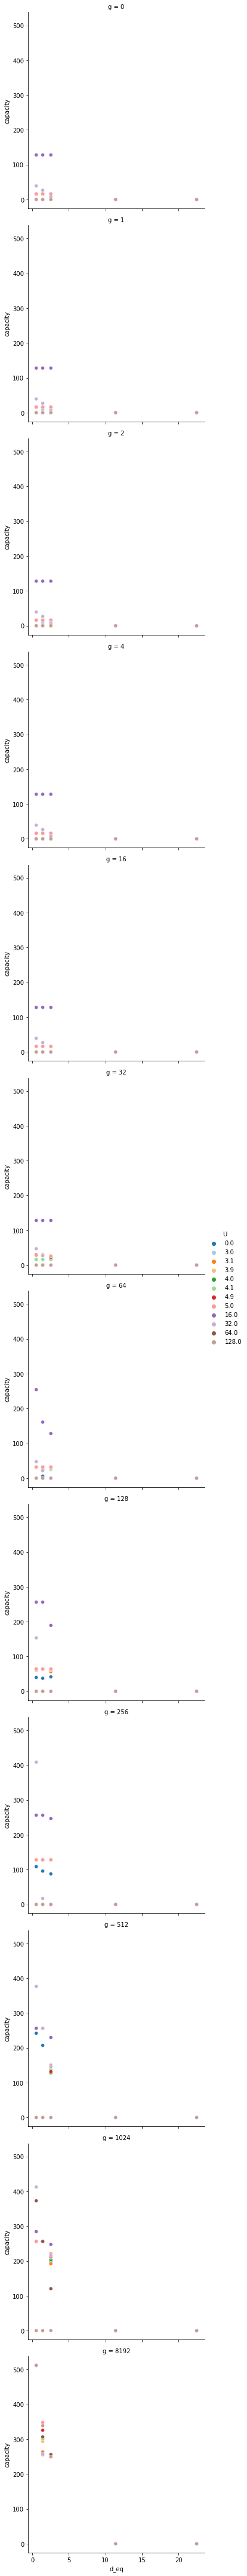

In [311]:
N=500
p=0.1

Np_filt = sum_max[(sum_max.N==N) & (sum_max.p==p)]

g = sns.relplot(x="d_eq", y="capacity", row="g", hue="U", data=Np_filt, kind="line", palette="tab20") #, ci=None

# g.axes[0,0].set_yscale('log')

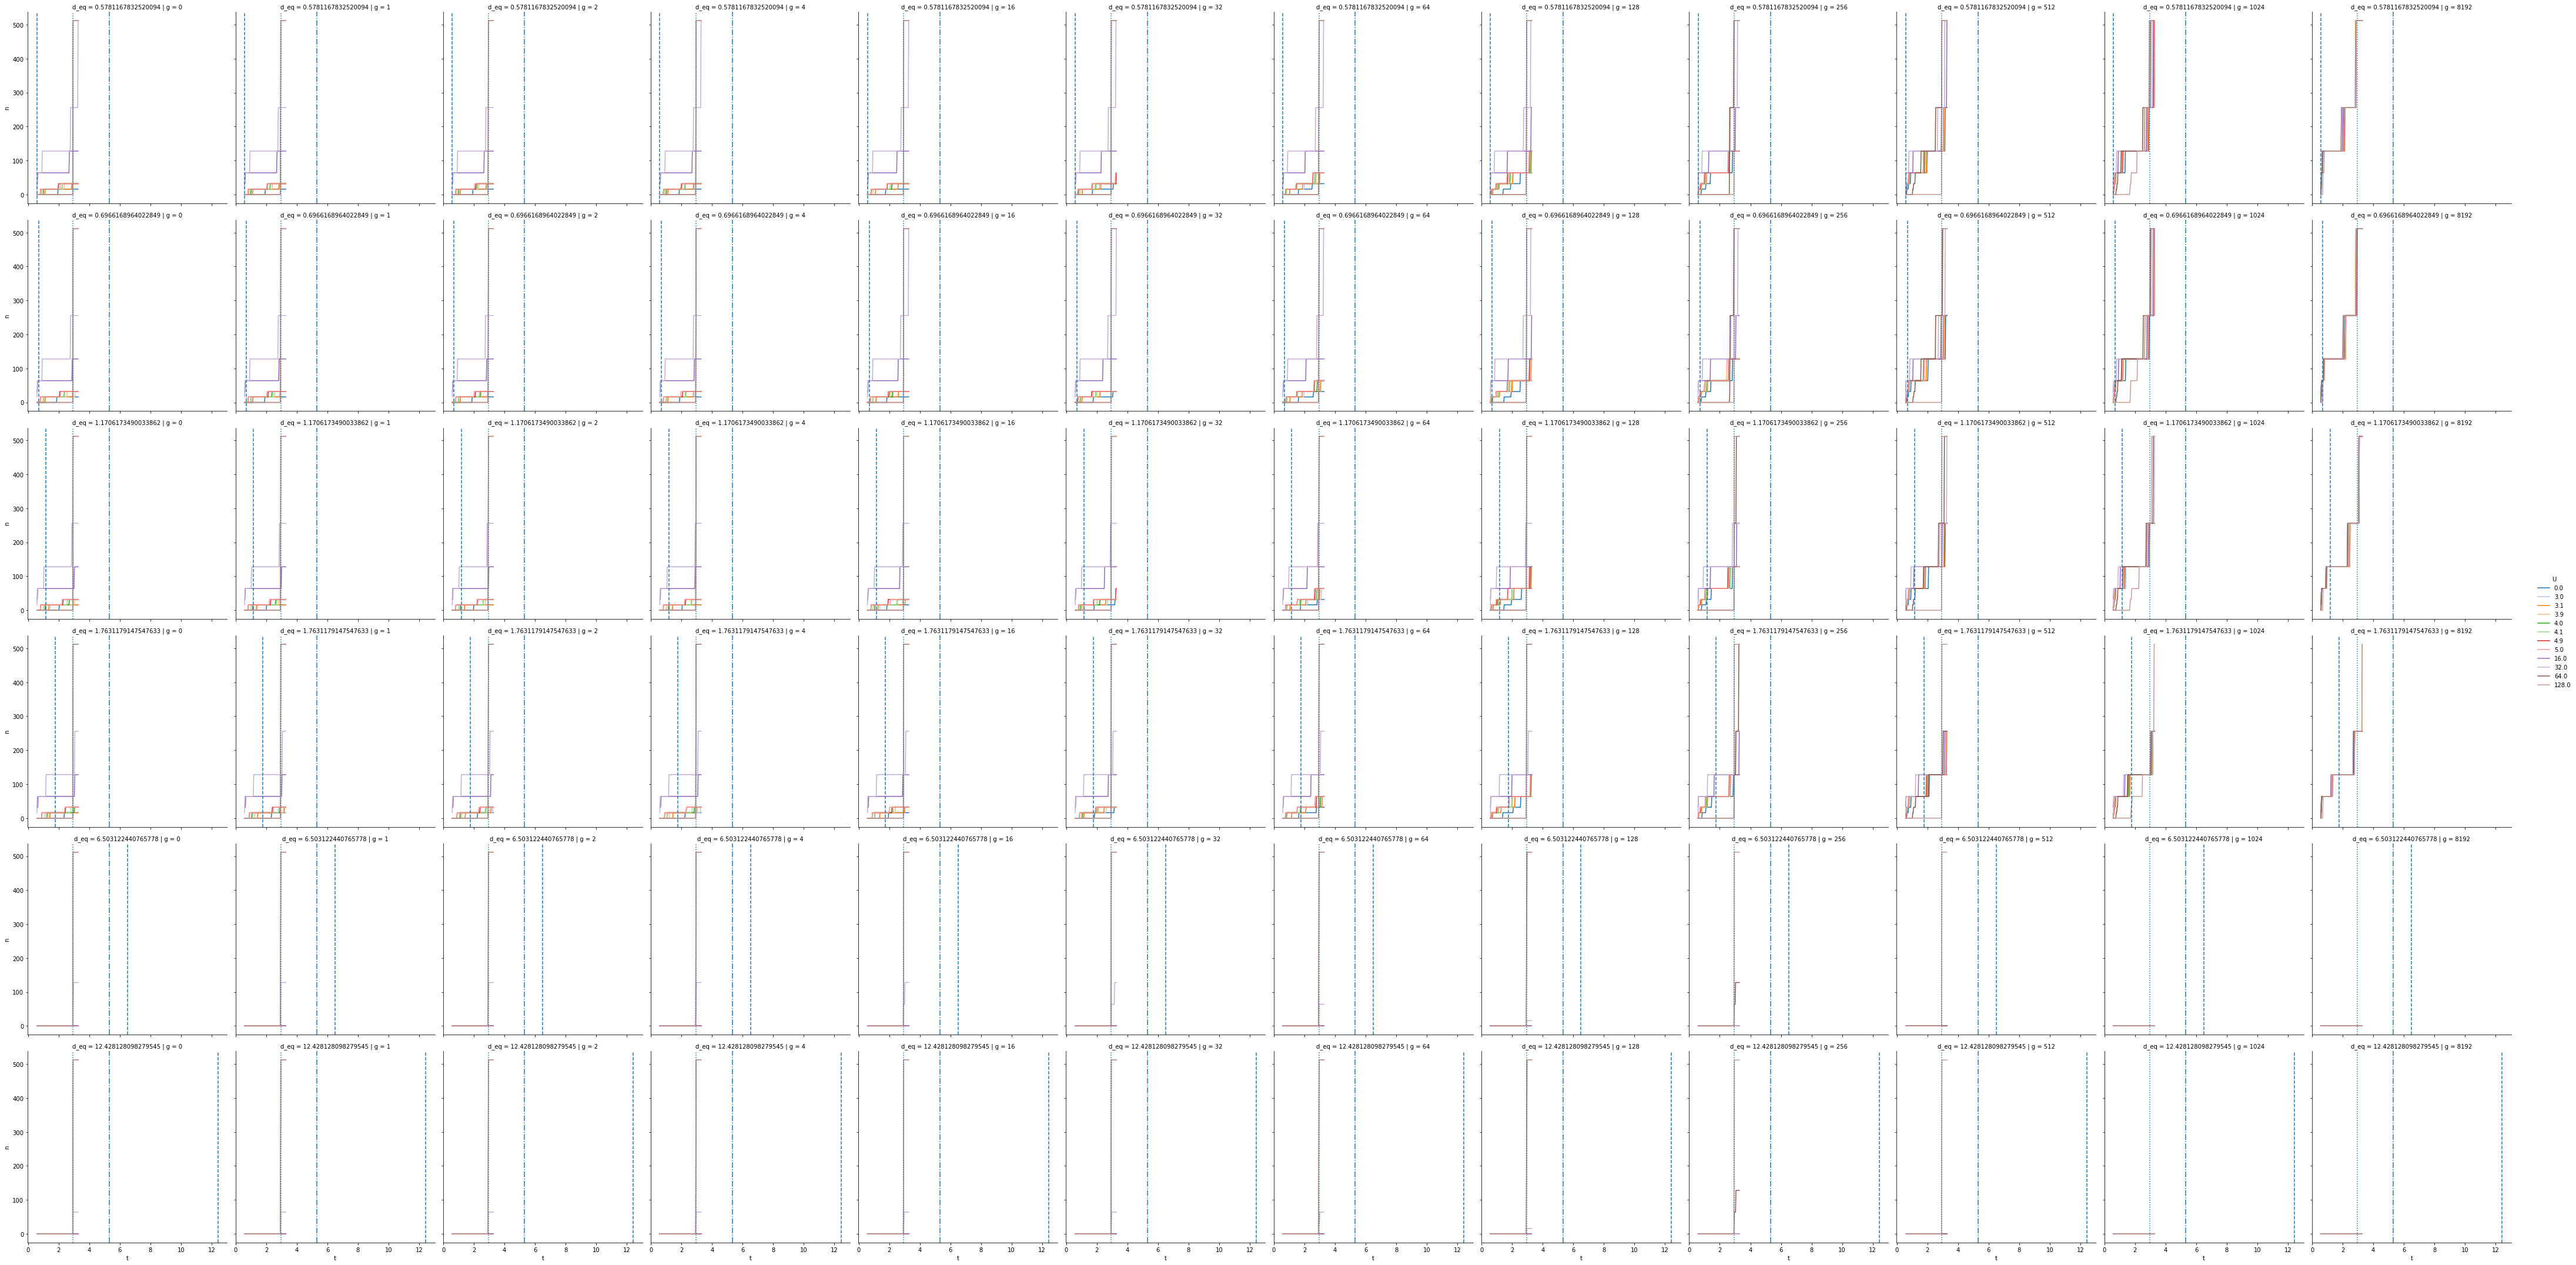

In [126]:
N=500
p=0.2

cap_filt = capacity[(capacity.N==N) & (capacity.p==p)]

g = sns.relplot(x="t", y="n", row="d_eq", col="g", hue="U", data=cap_filt, kind="line", palette="tab20") #, ci=None
# g.axes[0,0].set_yscale('log')
d_list = np.sort(cap_filt.d_eq.unique())

for i in range(len(d_list)):
    for j in range(len(g.axes[i])):
        g.axes[i,j].axvline(x=d_list[i],linestyle='--')
        coeff_filt = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        g.axes[i,j].axvline(x=float(coeff_filt.slope)*2*N*p+float(coeff_filt.intercept), linestyle='-.')
        g.axes[i,j].axvline(x=float(coeff_filt.slope)*N*p+float(coeff_filt.intercept), linestyle=':')

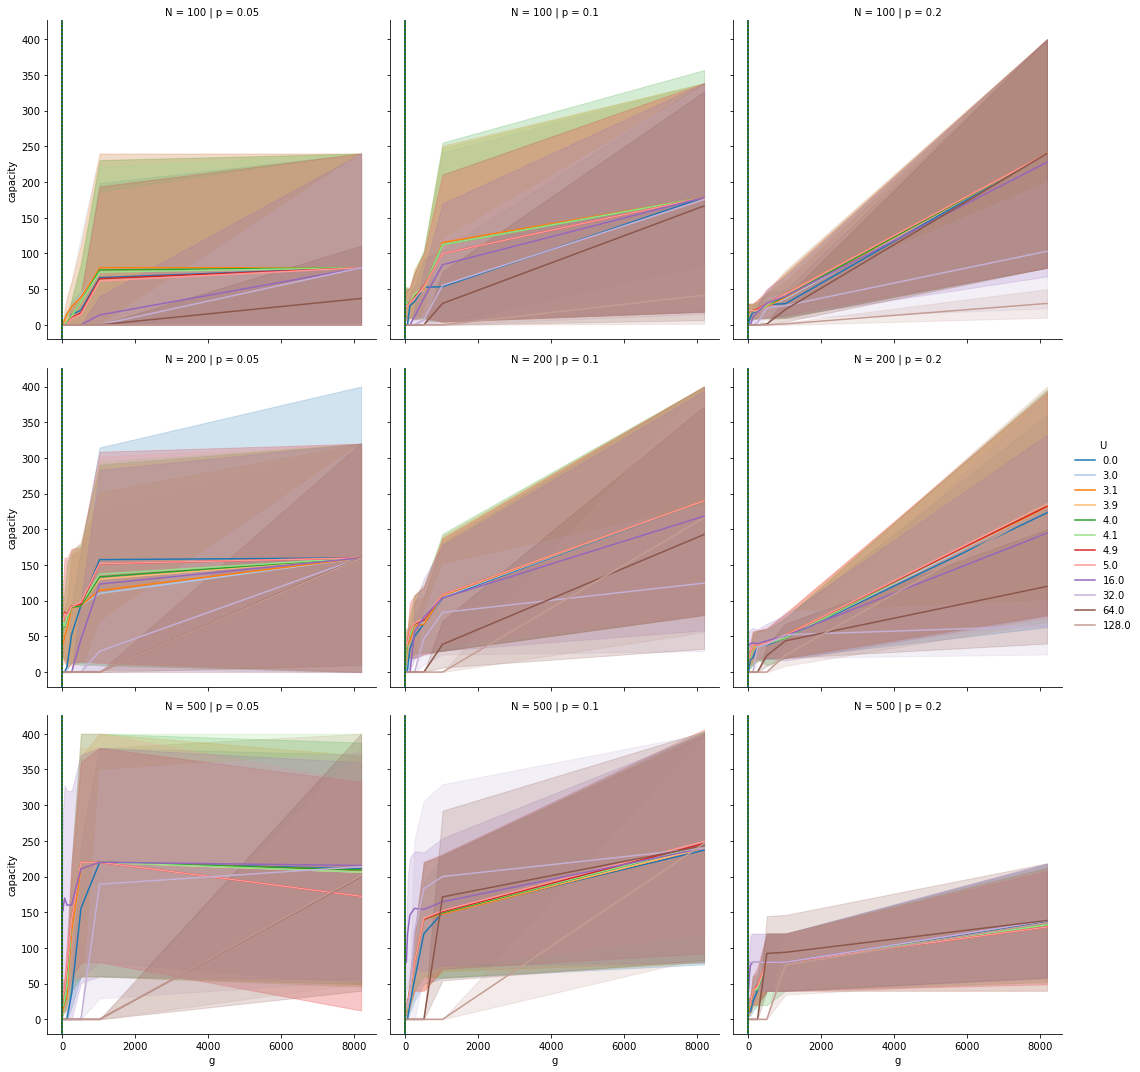

In [127]:
N=500
p=0.2

g = sns.relplot(x="g", y="capacity", col="p", row="N", hue="U", data=sum_max, kind="line", palette="tab20") #, ci=None
# g.axes[0,0].set_yscale('log')
d_list = np.sort(cap_filt.d_eq.unique())

for i in range(g.axes.shape[0]):
    for j in range(g.axes.shape[1]):
        g.axes[i,j].axvline(x=min_j,linestyle='--')
        coeff_filt = coeff_df[(coeff_df.N==N) & (coeff_df.p==p)]
        g.axes[i,j].axvline(x=float(coeff_filt.intercept),linestyle='-')
        g.axes[i,j].axvline(x=max_j, linestyle='-.')
        g.axes[i,j].axvline(x=min_i, color='r')
        g.axes[i,j].axvline(x=max_i, color='g')
        g.axes[i,j].axvline(x=float(coeff_filt.slope)*N*p+float(coeff_filt.intercept), linestyle=':')

## References

[1] Dasgupta, S., Stevens, C. F., & Navlakha, S. (2017). A neural algorithm for a fundamental computing problem. Science, 358(6364), 793-796. 

[2] Yagnik, J., Strelow, D., Ross, D. A., & Lin, R. S. (2011, November). The power of comparative reasoning. In 2011 International Conference on Computer Vision (pp. 2431-2438). IEEE.